# IMPORTS AND STATIC STUFF

In [1]:
import torch
import torch.nn as nn
#import mlflow
from utilities import *
import pandas as pd
import math
from torch.nn import CrossEntropyLoss, Softmax, BatchNorm1d, BCEWithLogitsLoss, Sigmoid
import pickle
from scipy import stats
from torch.utils.data import DataLoader, Dataset
from torch.nn import functional as F
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch.optim import Adam
from pathlib import Path
import random
import warnings

#ignore warning for computing mcc of 0.0
warnings.filterwarnings("ignore", category=RuntimeWarning)

### SETTING SEEDS ###
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

### STATIC PATHS ###
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "Data" / "BepiPred3Data" 
BEPIPRED3_AGAB_DATASET = DATA_DIR / "8AGABModelApproach" / "6CrossValidationDataset" 
BEPIPRED3_AGAB_SIMPLE_DATASET = DATA_DIR / "8AGABModelApproach" / "7SimpleApproachCrossValidationDataset" 
RESULTS_DIR = ROOT_DIR / "Results" 
FIGURE_DIR = RESULTS_DIR / "AgAbNeuralNetworks" / "Figures"
                
### SET GPU OR CPU ###
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

#TODO:
#Need to finish dataset before continuing (DONE)
#Need to set up collate function in this notebook and data to run through batch loader () 

#Option 1
#Concatenate all features 1281+1281+1281 before hand.

#Densenet setup 
#run padded sequence through one densenet architecture. 
#run light chain and heavy through separate densenet architectures.
#

cuda


# FUNCTIONS

In [63]:
def prepare_train_and_valid_loaders(train_valid_path, batch_size = 4,
                                    shuffle_batches=True, shuffle_val_antibodies=False):
    
    train_dataset, val_dataset = ag_ab_load_data(train_valid_path)
    y_train = train_dataset[1]
    lchain_train = train_dataset[2]
    hchain_train = train_dataset[3]
    antigen_train = train_dataset[4]
    train_dataset = list( zip(antigen_train, lchain_train, hchain_train, y_train) )
    
    y_val = val_dataset[1]
    lchain_val = val_dataset[2]
    hchain_val = val_dataset[3]
    antigen_val = val_dataset[4]
    
    if shuffle_val_antibodies:
        np.random.shuffle(lchain_val)
        np.random.shuffle(hchain_val)
        
    val_dataset = list( zip(antigen_val, lchain_val, hchain_val, y_val) )
    
    y_train_no_pred_power_ce_loss = compute_no_pred_power_performance(y_train)
    y_val_no_pred_power_ce_loss = compute_no_pred_power_performance(y_val)
    print(f"Expected train CE loss of model assigning class probability based on frequency: {y_train_no_pred_power_ce_loss} ")
    print(f"Expected val CE loss of model assigning class probability based on frequency: {y_val_no_pred_power_ce_loss} ")
    
    train_loader = DataLoader(train_dataset, batch_size= batch_size, collate_fn=pad_collate_batch, shuffle=shuffle_batches)
    valid_loader = DataLoader(val_dataset, batch_size= batch_size, collate_fn=pad_collate_batch, shuffle=shuffle_batches)
    
    return train_loader, valid_loader, y_train_no_pred_power_ce_loss , y_val_no_pred_power_ce_loss


def prepare_test_set_loader(test_path, batch_size = 1, accs_to_evaluate=None, shuffle_antibodies=False):
    """
    shuffle_antibodies: To test if antibodies are actually being used to antibody specific epitope predictions.
    """
    test_dataset = ag_ab_load_data(test_path, test_data = True)
    identifiers = test_dataset[0]
    y_test =  test_dataset[1]
    lchain_test =  test_dataset[2]
    hchain_test =  test_dataset[3]
    antigen_test =  test_dataset[4]
    
    if accs_to_evaluate is not None:
        complex_ids = [ids[3] for ids in identifiers]
        acc_idx_to_eval = [idx for b in accs_to_evaluate for idx, a in enumerate(complex_ids) if a==b]
        y_test_to_eval = list()
        lchain_test_to_eval = list()
        hchain_test_to_eval = list()
        antigen_test_to_eval = list()
        
        for idx in acc_idx_to_eval:
            y_test_to_eval.append(y_test[idx])
            lchain_test_to_eval.append(lchain_test[idx])
            hchain_test_to_eval.append(hchain_test[idx])
            antigen_test_to_eval.append(antigen_test[idx])
           
        
        y_test = np.asarray(y_test_to_eval, dtype="object")
        lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
        hchain_test = np.asarray(hchain_test_to_eval, dtype="object")
        antigen_test = np.asarray(antigen_test_to_eval, dtype="object")
    
    if shuffle_antibodies:
        np.random.shuffle(lchain_test)
        np.random.shuffle(hchain_test)
        
    test_dataset = list( zip(antigen_test, lchain_test, hchain_test, y_test) )
    test_loader = DataLoader(test_dataset, batch_size = batch_size, collate_fn=pad_collate_batch, shuffle=False)
    
    return test_loader

def pad_collate_batch(batch, padding_label = 2):
    """
    Inputs: batch: List of tuples: [(esm_representation, lchain, hchain, label)..batch_size]
                                   where esm_representations = (seq_len, embedding_size). The esm_embedding = 1280, 
            labels: numpy array. (seq_len,)
    Outputs: packed_esm_representations: packed sequence object, where sequences have been padded after longest sequence
                                         in batch. In this object, .data is the sequences is concatenated together. And 
                                         batch_sizes is list of time step batches. This tells the LSTM how to through 
                                         mulitple sequences in parallel. For example, 
                                         two sequences, abc and x, in a batch becomes:
                                         .data = axbc
                                         .batch_sizes = [2,1,1]
                                         So in the first iteration, the LSTM loads a resiude in from sequences. And in the
                                         remaining 2 iterations it works only on the abc sequence. 
    
                                         
             labels:                     0=Non-epitope, 1=epitope During training and evaluation.
    """
    batch = list(batch)
    esm_representations = [item[0] for item in batch]
    lchain_esm_representations = [item[1] for item in batch]
    hchain_esm_representations = [item[2] for item in batch]
    
    seq_lens = [len(esm_representation) for esm_representation in esm_representations]
    embedding_size = esm_representations[0].size()[1]
    labels = [torch.from_numpy(np.asarray(item[3], dtype="uint8")).long() for item in batch]
    num_of_seqs = len(esm_representations)
    
    #flatten each sequence: (num_of_seqs, seq_len, 1280) --> (num_of_seqs, 1280*seq_len)
    esm_representations = [torch.flatten(esm_representation) for esm_representation in esm_representations]
    #sort padded_esm_representation sequence from longest to shortest
    esm_representations = [esm_rep for _, esm_rep in sorted(zip(seq_lens, esm_representations), key=lambda pair: pair[0],
                                                            reverse=True)]
    #sort labels accordingly
    labels = [l for _, l in sorted(zip(seq_lens, labels), key=lambda pair: pair[0],
                                                            reverse=True)]
    #sort lchains accorindgly
    lchain_esm_representations = [l for _, l in sorted(zip(seq_lens, lchain_esm_representations), key=lambda pair: pair[0],
                                                            reverse=True)]
    #sort hchains accordingly
    hchain_esm_representations = [l for _, l in sorted(zip(seq_lens, hchain_esm_representations), key=lambda pair: pair[0],
                                                            reverse=True)]
    #sorted seq_lens
    seq_lens = [len(l) for l in labels]
    #add padding so they are all same length.
    padded_esm_representations = pad_sequence(esm_representations, batch_first = True)
    #reshape back to (num_of_seqs, seq_len, esm_embedding)
    padded_esm_representations = torch.reshape(padded_esm_representations, (num_of_seqs, -1, embedding_size))
    #padded labels
    labels = pad_sequence(labels, batch_first = True, padding_value = padding_label)
    #pack sequqence for LSTM optimization
    packed_esm_representations = pack_padded_sequence(padded_esm_representations, seq_lens, batch_first = True)
    
    #convert light and heavy chain to tensors
    lchain_esm_representations = torch.stack(lchain_esm_representations)
    hchain_esm_representations = torch.stack(hchain_esm_representations)
    
    return packed_esm_representations, lchain_esm_representations, hchain_esm_representations, labels


### TRAINING FUNCTIONS ###
def train(model, trainloader, validloader, criterion, optimizer,
          model_save_path, epochs = 20):
    
    min_valid_loss = np.inf
    best_val_auc = 0
    training_validation_scores_per_epoch = list()
    
    for e in range(epochs):
        #training evaluation metrics
        train_loss = 0.0
        no_pred_power_train_loss = 0.0
        #validation evaluation metrics
        valid_loss = 0.0
        model.train()
        
        for antigen, lchain, hchain, labels in trainloader:
            #tranfer data to gpu if available
            antigen = antigen.to(device)
            lchain = lchain.to(device)
            hchain = hchain.to(device)
            labels = labels.to(device)
            #clear gradients
            optimizer.zero_grad()
            #forward pass
            output = model(antigen, lchain, hchain)
            labels = torch.flatten(labels)
            loss = criterion(output, labels)
            #calculate gradients
            loss.backward()
            #update weights
            optimizer.step()
            #acummulate loss, accuracy, mcc and auc
            train_loss += loss.item()
            
        model.eval()
        val_model_outputs = list()
        val_all_labels = list()
        for antigen, lchain, hchain, labels in validloader:
            #tranfer data to gpu if available
            antigen = antigen.to(device)
            lchain = lchain.to(device)
            hchain = hchain.to(device)
            labels = labels.to(device)            
            #forward pass
            output = model(antigen, lchain, hchain)
            val_model_outputs.append(output)
            labels = torch.flatten(labels)
            val_all_labels.append(labels)
            loss = criterion(output, labels)
            valid_loss += loss.item()
            
        #average loss
        avg_train_loss = round(train_loss / len(trainloader), 6)
        avg_val_loss = round(valid_loss / len(validloader), 6)        
        training_validation_scores_per_epoch.append((avg_train_loss, avg_val_loss))
        #print some stats
        print(f"Epoch: {e+1}")
        print(f"Avg. train loss: {avg_train_loss}")
        print(f"Avg. val loss: {avg_val_loss}")
        #save model which has the best validation loss
        if min_valid_loss > valid_loss:
            print(f"Summed validation loss decreased: {round(min_valid_loss, 4)}-->{round(valid_loss,4)})")
            min_valid_loss = valid_loss

            #get validation metrics
            val_model_outputs = torch.cat(val_model_outputs, axis=0)
            val_all_labels = torch.cat(val_all_labels, axis=0)
            _, val_auc, val_mcc, val_mcc_threshold = get_performance_metrics(val_model_outputs, val_all_labels)
            print(f"Optimized validation MCC for this model: {round(val_mcc,4)}, using threshold of {round(val_mcc_threshold,4)}")
            print(f"Validation AUC for this model: {round(val_auc,4)}")
            #save state dict
            if val_auc > best_val_auc:
                print(f"Validation AUC increased: {round(best_val_auc,4)} --> {round(val_auc,4)}. Saving model.")
                model_save = model_save_path.parent / f"{model_save_path.name}_bestCELoss"
                #save state dict
                save_pytorch_model(model, model_save)
                best_val_auc = val_auc
                best_mcc_threshold = val_mcc_threshold
    
    return training_validation_scores_per_epoch, best_mcc_threshold

def run_train_val_cv(dataset, results_dir, initial_learning_rate,
                     epochs, weight_decay, batch_size = 4):
    
    fold_paths = list( dataset.glob("*Fold*") )
    num_of_folds = len(fold_paths)
    fold_count = 1
    best_mcc_thresholds = dict()
  
    for fold_path in fold_paths:
        
        print(f"Fold {fold_count} / {num_of_folds}")
        print(f"Loading data from {str(fold_path)}")
        train_loader, valid_loader, y_train_no_pred_power_ce_loss , y_val_no_pred_power_ce_loss = prepare_train_and_valid_loaders(fold_path, batch_size=batch_size)
        
        criterion = CrossEntropyLoss(ignore_index = 2)
        criterion.to(device)
        model = MyDenseNet()
        print(f"Model architecture to be used\n{model}") 
        model.to(device)
        optimizer = Adam(model.parameters(), lr=initial_learning_rate, weight_decay=weight_decay)
        model_save_path = results_dir / "models" / fold_path.stem
        
        training_validation_scores_per_epoch, best_mcc_threshold = train(model, train_loader, valid_loader, criterion, optimizer, model_save_path, epochs=epochs)
        best_mcc_thresholds[fold_path.stem] = best_mcc_threshold
#        best_mcc_thresholds.append(best_mcc_threshold)
        generate_training_validation_plots(training_validation_scores_per_epoch, y_train_no_pred_power_ce_loss, y_val_no_pred_power_ce_loss, results_dir / "graphs" / f"Fold{fold_count}")
        fold_count += 1
        
    #save best thresholds for models
    outfile = open(results_dir / "models" / "best_mcc_threshold.pickle", "wb")
    pickle.dump(best_mcc_thresholds, outfile)
        
def evaluate_models_with_roc_curve(model, model_states, best_mcc_thresholds, data_loader, plot_title,
                                   figure_save_path, antigen_only=False):
    ensemble_model_outputs = list()
    num_of_models = len(model_states)
    f, ax = plt.subplots(figsize=(10,8))
    criterion = CrossEntropyLoss(ignore_index = 2)
    all_preds = list()
    all_mccs = list()
    all_auc10 = list()
    all_aucs = list()
    y_true_repeat = list()
    all_recalls = list()
    all_precisions = list()
    all_f1_scores = list()
    all_accs = list()
    all_model_loss = list()
    all_pos_probs = list()
    all_thresh = list()
    overfit_threshs = list()
    
    for i in range(num_of_models):
        model_state = model_states[i]
        opt_thresh = best_mcc_thresholds[model_state.stem.split("_")[0]] 
    
        model_outputs = list()
        all_labels = list()
    
        model.load_state_dict(torch.load(model_state))
        model.eval()
    
        for antigen, lchain, hchain, labels in data_loader:
            
            if antigen_only:
                output= model(antigen)
            else:
                output = model(antigen, lchain, hchain)
            
            model_outputs.append(output)
            labels = torch.flatten(labels)
            all_labels.append(labels)
        
        #create ROC curve
        model_outputs = torch.cat(model_outputs, axis=0)
        all_labels = torch.cat(all_labels, axis=0)
        model_loss = criterion(model_outputs, all_labels)
        y_true_no_pad, y_pos_prob_no_pad = get_labels_preds_and_posprob_without_padding(model_outputs, all_labels)
        all_pos_probs.append(y_pos_prob_no_pad)
        y_true_repeat.append(y_true_no_pad)
        
#        all_y_true = all_labels.cpu().detach().tolist()
#        all_y_pos_prob = sigmoid(model_outputs).cpu().detach().tolist()

        fpr, tpr, auc, overfit_thresh = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
        auc10 = compute_auc10(fpr, tpr)
        acc, mcc, recall, precision, f1_score, predictions = metrics_with_threshold(y_true_no_pad, y_pos_prob_no_pad, opt_thresh)
        
        all_thresh.append(round(opt_thresh,3))
        overfit_threshs.append(round(overfit_thresh,3))
        
        print(f"Fold{i+1}")
        print(f"AUC10: {round(auc10,4)}")
        print(f"Neg. log. likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
        print(f"Positive recall: {recall} Precision: {round(precision,4)} F1-score: {round(f1_score,4)}")
        get_top_x_pos_probs_scores(y_pos_prob_no_pad, y_true_no_pad, opt_thresh, top=200)
        ax.plot(fpr, tpr, label = f"Fold{i+1} AUC: {round(auc,4)}")
        
        ensemble_model_outputs.append(model_outputs)
        all_preds.append(predictions)
        #collect all scores for a final average
        all_mccs.append(mcc)
        all_auc10.append(auc10)
        all_aucs.append(auc)
        all_recalls.append(recall)
        all_precisions.append(precision)
        all_f1_scores.append(f1_score)
        all_accs.append(acc)
        all_model_loss.append(model_loss)
        
    ensemble_model_outputs  = torch.mean(torch.stack(ensemble_model_outputs, axis=1), axis=1)
    model_loss = criterion(ensemble_model_outputs, all_labels)
    _, ensemble_pos_probs = get_labels_preds_and_posprob_without_padding(ensemble_model_outputs, all_labels)
    
    #create roc curve
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, ensemble_pos_probs)
    ensemble_preds = np.asarray(all_preds)
    num_datapoints = len(y_true_no_pad)
    auc10 = compute_auc10(fpr, tpr)
    #use majority vote for ensemble predictions
    ensemble_preds = [np.argmax( np.bincount(ensemble_preds[:, i]) ) for i in range(num_datapoints)]
    all_preds.append(ensemble_preds)
    acc, mcc, recall, precision, f1_score, _ = metrics_with_threshold(y_true_no_pad, ensemble_pos_probs, opt_thresh, ensemble=ensemble_preds)
    print(f"Ensemble AUC10 {round(auc10,4)} Neg. log likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
    print(f"Positive recall: {round(recall,4)} Precision: {round(precision,4)} F1-score: {round(f1_score,4)} when using optimized threshold")
    ax.plot(fpr, tpr, label = f"Ensemble AUC: {round(auc,4)}")
    
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--")
    ax.legend()
    ax.spines['right'].set_visible(False)
    
    ax.spines['top'].set_visible(False)
    plt.title(plot_title)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    figure_save_dir = figure_save_path.parent
    create_figure_save_path(figure_save_dir)
    plt.savefig(figure_save_path, dpi = 500, bbox_inches= "tight")
    plt.show()
    
    
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
    
    #including ensemble model in average
    all_mccs.append(mcc)
    
    #compute confusion matrix with best model according to MCC
    all_mccs = np.asarray(all_mccs)
    model_idx = np.argmax(all_mccs)
    
    all_pos_probs = np.asarray(all_pos_probs).flatten()
    y_true_repeat = np.asarray(y_true_repeat).flatten()
    #all fold models except ensemble 
    all_preds_flatten = np.asarray(all_preds[:-1]).flatten()
    
    fpr, tpr, auc, _ = get_fpr_tpr_auc_and_opt_threshold(y_true_repeat, all_pos_probs)
    auc10 = compute_auc10(fpr, tpr)
    acc = metrics.accuracy_score(y_true_repeat, all_preds_flatten)
    mcc = metrics.matthews_corrcoef(y_true_repeat, all_preds_flatten)
    recall = metrics.recall_score(y_true_repeat, all_preds_flatten)
    precision = metrics.precision_score(y_true_repeat, all_preds_flatten)
    f1_score = metrics.f1_score(y_true_repeat, all_preds_flatten)
    
    print(f"Concatenated all model predictions AUC: {auc}")
    print(f"Concatenated all model predictions AUC10: {auc10}")
    print(f"Concatenated all model predictions MCC: {mcc}")
    print(f"Concatenated all model predictions recall {recall}")
    print(f"Concatenated all model predictions precision: {precision}")
    print(f"Concatenated all model predictions F1 score: {f1_score}")
    print(f"Concatenated all model predictions accuracy: {acc}")
    latex_format = f"& {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}\n"
    
    print(f"Latex format: & {round(auc,3)} & {round(auc10,3)} & {round(mcc,3)} & {round(recall,3)} & {round(precision,3)} & {round(f1_score,3)} & {round(acc,3)}")
    
        
#    num_of_models += 1
    cm_analysis(y_true_no_pad, all_preds[model_idx], ["Non-epitope residue", "Epitope residue"], FIGURE_DIR)
    
    print(f"Average AUC across all models {round(sum(all_aucs)/num_of_models,3)}")
    print(f"Average AUC10 across all models {round(sum(all_auc10)/num_of_models,3)}")
    print(f"Average CE loss across all models {round(sum(all_model_loss).item()/num_of_models,3)}")
    print(f"Average MCC across all models {round(sum(all_mccs[:-1])/num_of_models,3)}")
    print(f"Fold threshold values: {all_thresh}")
    print(f"Average positive recall across all models {round(sum(all_recalls)/num_of_models,3)}")
    print(f"Average precision across all models {round(sum(all_precisions)/num_of_models,3)}")
    print(f"Average F1-score across all models {round(sum(all_f1_scores)/num_of_models,3)}")
    print(f"Average accuracy across all models {round(sum(all_accs)/num_of_models,3)}")
    print(f"Overfit threshold values {overfit_threshs}")
    
    return overfit_threshs, latex_format
    
def generate_training_validation_plots(train_val_scores_per_epoch,
                                       best_bad_model_train_performance,
                                       best_bad_model_val_performance,
                                       save_file):
    """
    Inputs: train_val_scores_per_epoch: List of tuples:
    [(avg_train_loss, avg_train_acc, avg_train_auc, avg_train_mcc,
    avg_val_loss, avg_val_acc, avg_val_auc, avg_val_mcc)...]
    
    save_path: Directory to save all plots in
    """
    
    epochs = [i for i in range(1, len(train_val_scores_per_epoch) + 1)]
    
    #get trains scores
    train_loss = [i[0] for i in train_val_scores_per_epoch]
#    train_acc = [i[1] for i in train_val_scores_per_epoch]
#    train_auc = [i[2] for i in train_val_scores_per_epoch]
#    train_mcc = [i[3] for i in train_val_scores_per_epoch]
    
    #get validation scores
    val_loss = [i[1] for i in train_val_scores_per_epoch]
#    val_acc = [i[5] for i in train_val_scores_per_epoch]
#    val_auc = [i[6] for i in train_val_scores_per_epoch]
#    val_mcc = [i[7] for i in train_val_scores_per_epoch]
    file_name = save_file.name
    save_path = save_file.parent
    create_figure_save_path(save_path)
    
    #loss score plots
    ax = plt.subplot()
    ax.plot(epochs, train_loss, label = "Training loss")
    plt.axhline(y=best_bad_model_train_performance, color='r', linestyle='-', label=f"Train upper bound {round(best_bad_model_train_performance,4)}")
    ax.plot(epochs, val_loss, label = "Validation loss")
    plt.axhline(y=best_bad_model_val_performance, color='r', linestyle='-', label=f"Val upper bound {round(best_bad_model_val_performance,4)}")
    ax.legend()
    plt.title("Training and validation loss")
    plt.ylabel("Average negative log. likelihood loss per epoch")
    plt.xlabel("Epochs")
    plt.savefig(save_path / f"{file_name}_loss", dpi = 1000)
    plt.clf()

# MODELS

In [71]:
class MyDenseNet(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1281,
                 fc1_lc_or_hc_size = 150,
                 fc2_lc_or_hc_size = 75,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 2):
        super(MyDenseNet, self).__init__()
        
        
        self.esm_embedding_size = esm_embedding_size
        self.fc1_lc_or_hc_size = fc1_lc_or_hc_size 
        self.fc2_lc_or_hc_size = fc2_lc_or_hc_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout
        
        #light chain densenet (batch*sequence lengths)
        self.light_chain_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
                                                 nn.ReLU(),
                                                 nn.Dropout(fc1_dropout),
                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        #heavy chain densenet (batch*sequence lengths)
        self.heavy_chain_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
                                                 nn.ReLU(),
                                                 nn.Dropout(fc1_dropout),
                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        
        #Positionwise antigen densenet (1281+50+50 from light and heavy chain)
        self.ff_model = nn.Sequential(nn.Linear(esm_embedding_size+fc2_lc_or_hc_size*2, fc1_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes))
        
    def forward(self, antigen, light_chain, heavy_chain):
        antigen, original_lengths = pad_packed_sequence(antigen, batch_first=True)
        batch_size = antigen.size(0)
        seq_len = antigen.size(1)
        #convert dim (N, L, esm_embedding) --> (N*L, esm_embedding)
        antigen = torch.reshape(antigen, (batch_size*seq_len, self.esm_embedding_size))
        
        #light and heavy chain repeats for as many positions in antigen. (N, esm_embedding) -> (N*L, esm_embedding)
#        light_chain = [pos.repeat(seq_len, 1) for pos in light_chain]
#        light_chain = torch.reshape(torch.stack(light_chain), (batch_size*seq_len, self.esm_embedding_size))
#        heavy_chain = [pos.repeat(seq_len, 1) for pos in heavy_chain]
#        heavy_chain = torch.reshape(torch.stack(heavy_chain), (batch_size*seq_len, self.esm_embedding_size))
        
        #get light chain features
        light_chain_features = self.light_chain_ff_model(light_chain)
        light_chain_features = torch.stack([chain.repeat(seq_len, 1) for chain in light_chain_features])
        light_chain_features = torch.reshape(light_chain_features, (batch_size*seq_len, self.fc2_lc_or_hc_size))
        #get heavy chain features
        heavy_chain_features = self.heavy_chain_ff_model(heavy_chain)
        heavy_chain_features = torch.stack([chain.repeat(seq_len, 1) for chain in heavy_chain_features])
        heavy_chain_features = torch.reshape(heavy_chain_features, (batch_size*seq_len, self.fc2_lc_or_hc_size))
        
        #concatenate antigen esm embeddings with light and heavy chain features
        antigen_antibody_features = torch.cat((antigen, light_chain_features, heavy_chain_features), axis=1)
        output = self.ff_model(antigen_antibody_features)                                               
        return output


class MyDenseNetAntigensOnly(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1281,
                 fc1_lc_or_hc_size = 150,
                 fc2_lc_or_hc_size = 75,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 2):
        super(MyDenseNetAntigensOnly, self).__init__()
        
        
        self.esm_embedding_size = esm_embedding_size
        self.fc1_lc_or_hc_size = fc1_lc_or_hc_size 
        self.fc2_lc_or_hc_size = fc2_lc_or_hc_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout
        
        #light chain densenet (batch*sequence lengths)
#        self.light_chain_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
#                                                 nn.ReLU(),
#                                                 nn.Dropout(fc1_dropout),
#                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        #heavy chain densenet (batch*sequence lengths)
#        self.heavy_chain_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
#                                                 nn.ReLU(),
#                                                 nn.Dropout(fc1_dropout),
#                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        
#        #Positionwise antigen densenet (1281+50+50 from light and heavy chain)
        self.ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes))
        
    def forward(self, antigen):
        antigen, original_lengths = pad_packed_sequence(antigen, batch_first=True)
        batch_size = antigen.size(0)
        seq_len = antigen.size(1)
        #convert dim (N, L, esm_embedding) --> (N*L, esm_embedding)
        antigen = torch.reshape(antigen, (batch_size*seq_len, self.esm_embedding_size))
        
        #light and heavy chain repeats for as many positions in antigen. (N, esm_embedding) -> (N*L, esm_embedding)
#        light_chain = [pos.repeat(seq_len, 1) for pos in light_chain]
#        light_chain = torch.reshape(torch.stack(light_chain), (batch_size*seq_len, self.esm_embedding_size))
#        heavy_chain = [pos.repeat(seq_len, 1) for pos in heavy_chain]
#        heavy_chain = torch.reshape(torch.stack(heavy_chain), (batch_size*seq_len, self.esm_embedding_size))
        
        #get light chain features
#        light_chain_features = self.light_chain_ff_model(light_chain)
#        light_chain_features = torch.stack([chain.repeat(seq_len, 1) for chain in light_chain_features])
#        light_chain_features = torch.reshape(light_chain_features, (batch_size*seq_len, self.fc2_lc_or_hc_size))
        #get heavy chain features
#        heavy_chain_features = self.heavy_chain_ff_model(heavy_chain)
#        heavy_chain_features = torch.stack([chain.repeat(seq_len, 1) for chain in heavy_chain_features])
#        heavy_chain_features = torch.reshape(heavy_chain_features, (batch_size*seq_len, self.fc2_lc_or_hc_size))
        
        #concatenate antigen esm embeddings with light and heavy chain features
#        antigen_antibody_features = torch.cat((antigen, light_chain_features, heavy_chain_features), axis=1)
        output = self.ff_model(antigen)                                               
        return output
    
    


# CROSSVALIDATION ON TRAIN-VAL DATASETS

In [40]:
#Might need to set on CPU, due to large memory requirements
device = torch.device("cpu")
run_train_val_cv(BEPIPRED3_AGAB_SIMPLE_DATASET, RESULTS_DIR / "AgAbNeuralNetworks", 0.0001, 2, weight_decay=0.005)

Fold 1 / 5
Loading data from C:\Users\Joaki\OneDrive\Skrivebord\SpecialProject\Code\BepiPred\Data\BepiPred3Data\8AGABModelApproach\7SimpleApproachCrossValidationDataset\Fold1.npz
Expected train CE loss of model assigning class probability based on frequency: 0.20367169188363368 
Expected val CE loss of model assigning class probability based on frequency: 0.2081551967820292 
Model architecture to be used
MyDenseNet(
  (light_chain_ff_model): Sequential(
    (0): Linear(in_features=1281, out_features=150, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=150, out_features=75, bias=True)
  )
  (heavy_chain_ff_model): Sequential(
    (0): Linear(in_features=1281, out_features=150, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=False)
    (3): Linear(in_features=150, out_features=75, bias=True)
  )
  (ff_model): Sequential(
    (0): Linear(in_features=1431, out_features=180, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.7, inplace=F

KeyboardInterrupt: 

# TEST/EVAL PERFORMANCE

Fold1
AUC10: 0.2369
Neg. log. likelihood loss: 0.2391 Accuracy: 0.6183 MCC: 0.2289
Positive recall: 0.8221797323135756 Precision: 0.1481 F1-score: 0.251
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.33
Recall: 1.0
Precision: 0.33
Fold2
AUC10: 0.2849
Neg. log. likelihood loss: 0.2335 Accuracy: 0.6812 MCC: 0.2243
Positive recall: 0.722753346080306 Precision: 0.159 F1-score: 0.2607
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.31
Recall: 1.0
Precision: 0.31
Fold3
AUC10: 0.2667
Neg. log. likelihood loss: 0.2337 Accuracy: 0.6722 MCC: 0.2261
Positive recall: 0.739961759082218 Precision: 0.1576 F1-score: 0.2599
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.385
Recall: 1.0
Precision: 0.385
Fold4
AUC10: 0.2672
Neg. log. likelihood loss: 0.2347 Accuracy: 0.3547 MCC: 0.1605
Positive recall: 0.9665391969407265 Precision: 0.1047 F1-score: 0.189
Accuaracy, recall and precision on top-200 assig

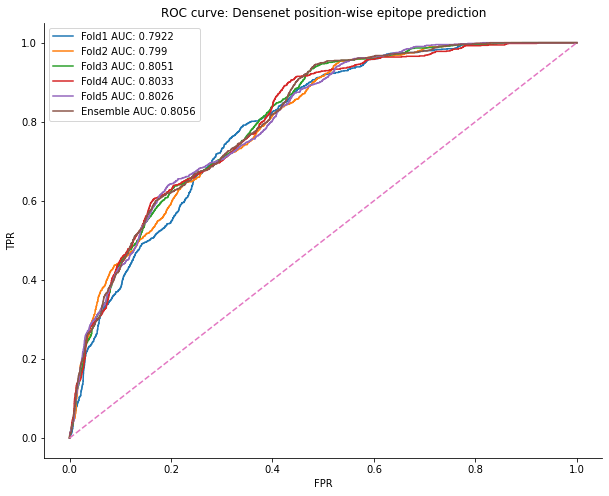

Concatenated all model predictions AUC: 0.7992691184162717
Concatenated all model predictions AUC10: 0.2649948225380003
Concatenated all model predictions MCC: 0.21082523288091273
Concatenated all model predictions recall 0.7768642447418738
Concatenated all model predictions precision: 0.1443031680636454
Concatenated all model predictions F1 score: 0.24339543521236445
Concatenated all model predictions accuracy: 0.6243586883783181
Latex format: & 0.799 & 0.265 & 0.211 & 0.777 & 0.144 & 0.243 & 0.624
Average AUC across all models 0.8
Average AUC10 across all models 0.266
Average CE loss across all models 0.235
Average MCC across all models 0.225
Fold threshold values: [0.078, 0.078, 0.078, 0.039, 0.116]
Average positive recall across all models 0.777
Average precision across all models 0.158
Average F1-score across all models 0.257
Average accuracy across all models 0.624
Overfit threshold values [0.085, 0.046, 0.056, 0.063, 0.115]


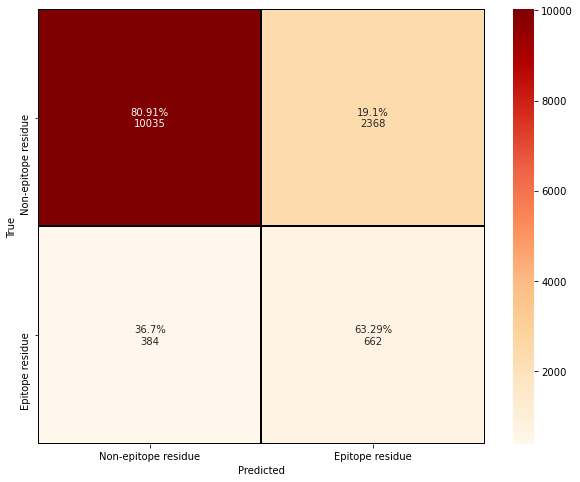

In [72]:

test_path = BEPIPRED3_AGAB_SIMPLE_DATASET / "test.npz"
test_set_loader = prepare_test_set_loader(test_path, batch_size = 4)

#model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp1" / "models"
#model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp2" / "models"
#model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp3" / "models"
#model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp4" / "models"
#model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp4" / "models"
model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp_without_abs" / "models"


best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))
best_ce_loss_models = list( model_path.glob("*bestCELoss*") )
plot_title = "ROC curve: Densenet position-wise epitope prediction"



#model = MyDenseNet()
model = MyDenseNetAntigensOnly()
#_, _ = evaluate_models_with_roc_curve(model, best_ce_loss_models, best_mcc_thresholds,  test_set_loader, plot_title, FIGURE_DIR / "roc_curve")
_, _ = evaluate_models_with_roc_curve(model, best_ce_loss_models, best_mcc_thresholds,  test_set_loader, plot_title, FIGURE_DIR / "roc_curve", antigen_only=True)


# Test Eval Performance on individual proteins

C:\Users\Joaki\AppData\Local\Temp/ipykernel_17788/1342132951.py:52: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_17788/1342132951.py:53: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Fold1
AUC10: 0.1345
Neg. log. likelihood loss: 0.2654 Accuracy: 0.5778 MCC: 0.142
Positive recall: 0.6900826446280992 Precision: 0.1246 F1-score: 0.2111
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.2
Recall: 1.0
Precision: 0.2
Fold2
AUC10: 0.1529
Neg. log. likelihood loss: 0.26 Accuracy: 0.6844 MCC: 0.1779
Positive recall: 0.6157024793388429 Precision: 0.1507 F1-score: 0.2421
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.245
Recall: 1.0
Precision: 0.245
Fold3
AUC10: 0.1908
Neg. log. likelihood loss: 0.2579 Accuracy: 0.705 MCC: 0.1793
Positive recall: 0.5867768595041323 Precision: 0.1554 F1-score: 0.2457
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.275
Recall: 1.0
Precision: 0.275
Fold4
AUC10: 0.1695
Neg. log. likelihood loss: 0.26 Accuracy: 0.4865 MCC: 0.1818
Positive recall: 0.8760330578512396 Precision: 0.1247 F1-score: 0.2183
Accuaracy, recall and precision on top-200 assign

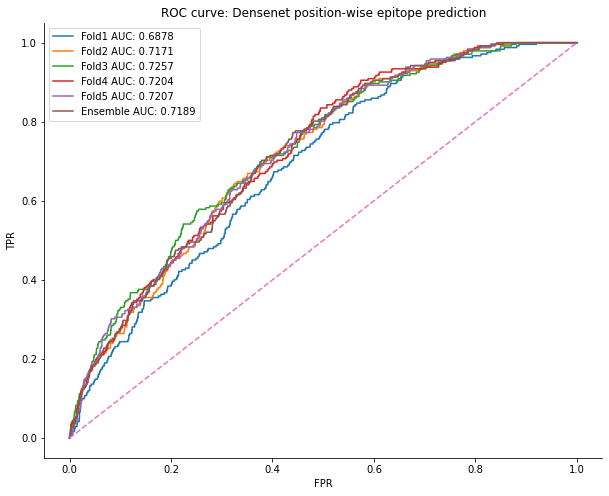

Concatenated all model predictions AUC: 0.7137161458491933
Concatenated all model predictions AUC10: 0.16981918061840356
Concatenated all model predictions MCC: 0.16791306320009639
Concatenated all model predictions recall 0.6900826446280992
Concatenated all model predictions precision: 0.1367283445226789
Concatenated all model predictions F1 score: 0.22823561568949022
Concatenated all model predictions accuracy: 0.6179296346414073
Latex format: & 0.714 & 0.17 & 0.168 & 0.69 & 0.137 & 0.228 & 0.618
Average AUC across all models 0.714
Average AUC10 across all models 0.16
Average CE loss across all models 0.26
Average MCC across all models 0.171
Fold threshold values: [0.078, 0.097, 0.097, 0.058, 0.078]
Average positive recall across all models 0.69
Average precision across all models 0.139
Average F1-score across all models 0.23
Average accuracy across all models 0.618
Overfit threshold values [0.058, 0.094, 0.102, 0.065, 0.066]


([0.058, 0.094, 0.102, 0.065, 0.066],
 '& 0.714 & 0.17 & 0.168 & 0.69 & 0.137 & 0.228 & 0.618\n')

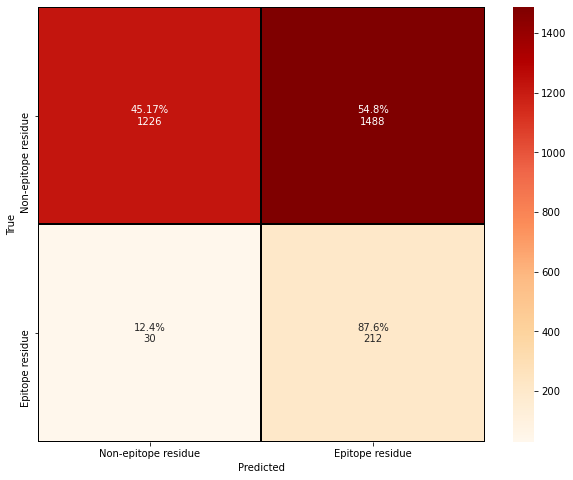

In [8]:
test_identifiers = [['1k4c_B', '1k4c_A', '1k4c_C', 'ComplexID_47'],
                    ['1s5h_A', '1s5h_B', '1s5h_C', 'ComplexID_97'],
                    ['1zwi_B', '1zwi_A', '1zwi_C', 'ComplexID_131'],
                    ['2atk_B', '2atk_A', '2atk_C', 'ComplexID_137'],
                    ['2h8p_B', '2h8p_A', '2h8p_C', 'ComplexID_156'],
                    ['2hfe_B', '2hfe_A', '2hfe_C', 'ComplexID_159'],
                    ['2hvj_B', '2hvj_A', '2hvj_C', 'ComplexID_161'],
                    ['2ih1_B', '2ih1_A', '2ih1_C', 'ComplexID_166'],
                    ['2ih3_B', '2ih3_A', '2ih3_C', 'ComplexID_167'],
                    ['2nlj_A', '2nlj_B', '2nlj_C', 'ComplexID_174'],
                    ['2p7t_B', '2p7t_A', '2p7t_C', 'ComplexID_187'],
                    ['2w0f_B', '2w0f_A', '2w0f_C', 'ComplexID_208'],
                    ['2xwt_B', '2xwt_A', '2xwt_C', 'Test_ComplexID_219'],
                    ['3fb5_B', '3fb5_A', '3fb5_C', 'ComplexID_259'],
                    ['3g04_A', '3g04_B', '3g04_C', 'ComplexID_260'],
                    ['3or6_B', '3or6_A', '3or6_C', 'ComplexID_340'],
                    ['3or7_B', '3or7_A', '3or7_C', 'ComplexID_341'],
                    ['3stl_B', '3stl_A', '3stl_C', 'ComplexID_378'],
                    ['3stz_B', '3stz_A', '3stz_C', 'ComplexID_379'],
                    ['4f37_L', '4f37_H', '4f37_A', 'ComplexID_469'],
                    ['4i9w_D', '4i9w_E', '4i9w_A', 'ComplexID_521'],
                    ['4i9w_F', '4i9w_G', '4i9w_A', 'ComplexID_522'],
                    ['4i9w_D', '4i9w_E', '4i9w_B', 'ComplexID_523'],
                    ['4i9w_F', '4i9w_G', '4i9w_B', 'ComplexID_524'],
                    ['4lbe_B', '4lbe_A', '4lbe_C', 'ComplexID_566'],
                    ['4lcu_B', '4lcu_A', '4lcu_C', 'ComplexID_567'],
                    ['4msw_B', '4msw_A', '4msw_C', 'ComplexID_602'],
                    ['4qci_A', '4qci_B', '4qci_C', 'ComplexID_641'],
                    ['4qci_L', '4qci_H', '4qci_C', 'ComplexID_642'],
                    ['4qci_A', '4qci_B', '4qci_D', 'Test_ComplexID_643'],
                    ['4qci_L', '4qci_H', '4qci_D', 'Test_ComplexID_644'],
                    ['4uuj_B', '4uuj_A', '4uuj_C', 'ComplexID_689'],
                    ['4wfe_D', '4wfe_E', '4wfe_B', 'ComplexID_692'],
                    ['4wfe_F', '4wfe_G', '4wfe_B', 'ComplexID_693'],
                    ['5c0n_L', '5c0n_H', '5c0n_A', 'ComplexID_824'],
                    ['5c0n_D', '5c0n_C', '5c0n_A', 'ComplexID_825'],
                    ['5d8j_L', '5d8j_H', '5d8j_A', 'Test_ComplexID_840'],
                    ['5ebl_B', '5ebl_A', '5ebl_C', 'ComplexID_859'],
                    ['5ebm_B', '5ebm_A', '5ebm_C', 'ComplexID_860'],
                    ['5ebw_B', '5ebw_A', '5ebw_C', 'ComplexID_861'],
                    ['5ec1_B', '5ec1_A', '5ec1_C', 'ComplexID_862'],
                    ['5ec2_B', '5ec2_A', '5ec2_C', 'ComplexID_863'],
                    ['5j9p_B', '5j9p_A', '5j9p_C', 'ComplexID_925'],
                    ['5th9_L', '5th9_H', '5th9_A', 'Test_ComplexID_1030'],
                    ['5th9_N', '5th9_J', '5th9_C', 'ComplexID_1031'],
                    ['5vk6_B', '5vk6_A', '5vk6_C', 'ComplexID_1096'],
                    ['5vke_B', '5vke_A', '5vke_C', 'ComplexID_1098'],
                    ['5vkh_B', '5vkh_A', '5vkh_C', 'ComplexID_1099'],
                    ['6by2_B', '6by2_A', '6by2_C', 'ComplexID_1256'],
                    ['6by3_B', '6by3_A', '6by3_C', 'ComplexID_1257'],
                    ['6hga_L', '6hga_H', '6hga_B', 'Test_ComplexID_1333'],
                    ['6nfu_B', '6nfu_A', '6nfu_C', 'ComplexID_1455'],
                    ['6nfv_B', '6nfv_A', '6nfv_C', 'ComplexID_1456'],
                    ['6ohg_B', '6ohg_C', '6ohg_A', 'ComplexID_1510'],
                    ['6pis_L', '6pis_H', '6pis_A', 'ComplexID_1537'],
                    ['6pis_M', '6pis_I', '6pis_A', 'ComplexID_1538'],
                    ['6pis_L', '6pis_H', '6pis_B', 'ComplexID_1539'],
                    ['6pis_M', '6pis_I', '6pis_B', 'ComplexID_1540'],
                    ['6u6u_L', '6u6u_H', '6u6u_R', 'Test_ComplexID_1599'],
                    ['6vtw_L', '6vtw_H', '6vtw_A', 'Test_ComplexID_1641'],
                    ['6ywc_B', '6ywc_A', '6ywc_C', 'ComplexID_1762'],
                    ['6ywc_E', '6ywc_D', '6ywc_F', 'ComplexID_1763'],
                    ['7lj4_D', '7lj4_E', '7lj4_A', 'ComplexID_1933'],
                    ['7lj4_F', '7lj4_G', '7lj4_A', 'ComplexID_1934'],
                    ['7lj4_D', '7lj4_E', '7lj4_B', 'Test_ComplexID_1935'],
                    ['7lj4_F', '7lj4_G', '7lj4_B', 'Test_ComplexID_1936'],
                    ['7lj5_D', '7lj5_E', '7lj5_A', 'ComplexID_1937'],
                    ['7lj5_F', '7lj5_G', '7lj5_A', 'ComplexID_1938'],
                    ['7lj5_D', '7lj5_E', '7lj5_B', 'ComplexID_1939'],
                    ['7lj5_F', '7lj5_G', '7lj5_B', 'ComplexID_1940'],
                    ['7ljb_D', '7ljb_E', '7ljb_A', 'ComplexID_1941'],
                    ['7ljb_F', '7ljb_G', '7ljb_A', 'ComplexID_1942'],
                    ['7ljb_D', '7ljb_E', '7ljb_B', 'ComplexID_1943'],
                    ['7ljb_F', '7ljb_G', '7ljb_B', 'ComplexID_1944'],
                    ['5f72_T_L', '5f72_T_H', '5f72_K', 'Test_ComplexID_2066'],
                    ['5f72_S_L', '5f72_S_H', '5f72_K', 'Test_ComplexID_2067'],
                    ['6g8r_A_L', '6g8r_A_H', '6g8r_B', 'ComplexID_2090'],
                    ['6y6c_C_L', '6y6c_C_H', '6y6c_A', 'Test_ComplexID_2100'],
                    ['6y6c_D_L', '6y6c_D_H', '6y6c_A', 'Test_ComplexID_2101'],
                    ['7jum_H_L', '7jum_H_H', '7jum_A', 'Test_ComplexID_2113'],
                    ['7jum_I_L', '7jum_I_H', '7jum_A', 'Test_ComplexID_2114'],
                    ['7jum_H_L', '7jum_H_H', '7jum_B', 'ComplexID_2115'],
                    ['7jum_I_L', '7jum_I_H', '7jum_B', 'ComplexID_2116'],
                    ['7jum_J_L', '7jum_J_H', '7jum_B', 'ComplexID_2117'],
                    ['7jum_J_L', '7jum_J_H', '7jum_C', 'ComplexID_2118']]

#print(test_identifiers)
test_identifiers_same_as_ag_only_model = [test_id for test_id in test_identifiers if test_id[3].startswith("Test")]                                                                                                

model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp4" / "models"
best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))
best_ce_loss_models = list( model_path.glob("*bestCELoss*") )
model = MyDenseNet()


latex_formats = str()
overfit_test_proteins_thresholds = list()

#evalaute individually on all antigens
#for test_identifier in test_identifiers:
#    light_chain_id = test_identifier[0]
#    heavy_chain_id = test_identifier[1]
#    antigen_id = test_identifier[2]
#    complex_id = test_identifier[3]
#    plot_title = f"ROC curve: Densenet position-wise epitope prediction for antigen {antigen_id}"
#    test_set_loader = prepare_test_set_loader(test_path, batch_size = 4, accs_to_evaluate=[complex_id])
#    overfit_test_protein_thresholds, latex_format = evaluate_models_with_roc_curve(model, best_ce_loss_models, best_mcc_thresholds,  test_set_loader, plot_title, FIGURE_DIR / "roc_curve" )
#        
#    latex_formats += f"({antigen_id},{light_chain_id},{heavy_chain_id}) {latex_format}"
#    overfit_test_proteins_thresholds.append(overfit_test_protein_thresholds)
    
#evaluate individually only on antigens in antigen only model
#for test_identifier in test_identifiers_same_as_ag_only_model:
#    light_chain_id = test_identifier[0]
#    heavy_chain_id = test_identifier[1]
#    antigen_id = test_identifier[2]
#    complex_id = test_identifier[3]
#    plot_title = f"ROC curve: Densenet position-wise epitope prediction for antigen {antigen_id}"
#    test_set_loader = prepare_test_set_loader(test_path, batch_size = 4, accs_to_evaluate=[complex_id])
#    overfit_test_protein_thresholds, latex_format = evaluate_models_with_roc_curve(model, best_ce_loss_models, best_mcc_thresholds,  test_set_loader, plot_title, FIGURE_DIR / "roc_curve" )
#        
#    latex_formats += f"({antigen_id},{light_chain_id},{heavy_chain_id}) {latex_format}"
#    overfit_test_proteins_thresholds.append(overfit_test_protein_thresholds)

#print(test_identifiers_same_as_ag_only_model)

#overall evaluation of antigen only model
plot_title = f"ROC curve: Densenet position-wise epitope prediction"
complex_ids = [test_id[3] for test_id in test_identifiers_same_as_ag_only_model]
test_set_loader = prepare_test_set_loader(test_path, batch_size = 4, accs_to_evaluate=complex_ids)
evaluate_models_with_roc_curve(model, best_ce_loss_models, best_mcc_thresholds,  test_set_loader, plot_title, FIGURE_DIR / "roc_curve" )

In [26]:
print(latex_formats)

(1k4c_C,1k4c_B,1k4c_A) & 0.803 & 0.27 & 0.277 & 0.786 & 0.243 & 0.372 & 0.639
(1s5h_C,1s5h_A,1s5h_B) & 0.829 & 0.318 & 0.3 & 0.831 & 0.239 & 0.371 & 0.645
(1zwi_C,1zwi_B,1zwi_A) & 0.842 & 0.364 & 0.295 & 0.815 & 0.239 & 0.369 & 0.649
(2atk_C,2atk_B,2atk_A) & 0.84 & 0.319 & 0.317 & 0.829 & 0.26 & 0.396 & 0.656
(2h8p_C,2h8p_B,2h8p_A) & 0.903 & 0.676 & 0.381 & 0.831 & 0.394 & 0.535 & 0.67
(2hfe_C,2hfe_B,2hfe_A) & 0.903 & 0.676 & 0.381 & 0.831 & 0.394 & 0.535 & 0.67
(2hvj_C,2hvj_B,2hvj_A) & 0.826 & 0.27 & 0.311 & 0.829 & 0.257 & 0.392 & 0.65
(2ih1_C,2ih1_B,2ih1_A) & 0.85 & 0.447 & 0.31 & 0.857 & 0.253 & 0.391 & 0.626
(2ih3_C,2ih3_B,2ih3_A) & 0.833 & 0.45 & 0.268 & 0.8 & 0.243 & 0.373 & 0.612
(2nlj_C,2nlj_A,2nlj_B) & 0.829 & 0.296 & 0.302 & 0.831 & 0.24 & 0.372 & 0.647
(2p7t_C,2p7t_B,2p7t_A) & 0.832 & 0.322 & 0.3 & 0.815 & 0.242 & 0.373 & 0.654
(2w0f_C,2w0f_B,2w0f_A) & 0.826 & 0.261 & 0.303 & 0.829 & 0.252 & 0.387 & 0.639
(2xwt_C,2xwt_B,2xwt_A) & 0.837 & 0.232 & 0.304 & 0.889 & 0.219 & 0.35

# Other Analysis

Proteins with AUC score above 0.6 and positive epitope ratio between 0 and 0.2: 1211
Proteins with AUC above 0.5 1698 out of 2043
Proteins with AUC above 0.6 1265 out of 2043
Proteins with AUC above 0.7 593 out of 2043
Proteins with AUC above 0.75 350 out of 2043


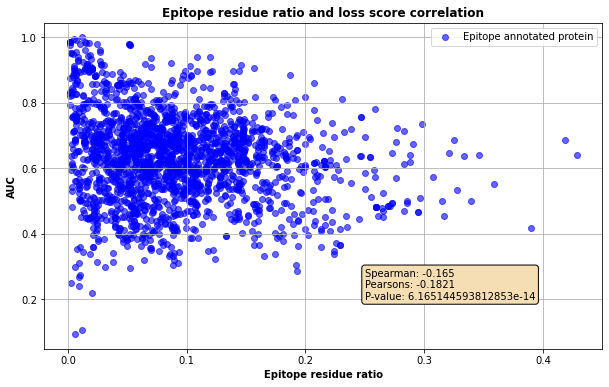

In [74]:
#Might need to set on CPU, due to large memory requirements
device = torch.device("cpu")

def generate_sorted_by_num_of_pos_anno_preds(model, model_states, best_mcc_thresholds, dataset, antigen_only=False):
    
    #go through each fold
    fold_paths = list( dataset.glob("*Fold*") )
    criterion = CrossEntropyLoss(ignore_index = 2)
    num_of_folds = len(fold_paths)
    fold_results = list()
    
    for i in range(num_of_folds):
        fold_path = fold_paths[i]
        model_state = model_states[i]
        print(model_state)
        opt_thresh = best_mcc_thresholds[model_state.stem.split("_")[0]]
        print(f"Fold {i+1} / {num_of_folds}")
        print(f"Loading data from {str(fold_path)}")
        _, valid_loader, _ , _ = prepare_train_and_valid_loaders(fold_path, batch_size=1, shuffle_batches=False)
  #      _, valid_loader, _ , _ = prepare_train_and_valid_loaders(fold_path, batch_size=1, shuffle_batches=False, shuffle_val_antibodies=True)
    
        val_ce_loss_scores = np.zeros(len(valid_loader))
        val_mcc_scores = np.zeros(len(valid_loader))
        val_auc_scores = np.zeros(len(valid_loader))
        val_auc10_scores = np.zeros(len(valid_loader))
        val_overfit_threshs = np.zeros(len(valid_loader))
        
        val_pos_epi_ratios = np.zeros(len(valid_loader))        
        model.load_state_dict(torch.load(model_state))
        model.eval()
        j = 0
        
        val_model_outputs = list()
        val_all_labels = list()
        
        for antigen, lchain, hchain, labels in valid_loader:
            antigen = antigen.to(device)
            lchain = lchain.to(device)
            hchain = hchain.to(device)
            labels = labels.to(device)
            #forward pass
            if antigen_only:
                output = model(antigen)
            else:
                output = model(antigen, lchain, hchain)
            val_model_outputs.append(output)
            labels = torch.flatten(labels)
            val_all_labels.append(labels)
#            labels = torch.flatten(labels)
#            print(labels)
            count_anno = torch.bincount(labels)
            pos_epi_count, total_count = (count_anno[1], count_anno[0] + count_anno[1])
            pos_epi_ratio = pos_epi_count / total_count
            
            #complete negatives (this assume that there aren't complete positives)
#            elif len(count_anno) == 1:
#                print("Complete negative detected")
#               pos_epi_ratio = 0
#                
#            else:
#                print("Someting is wrong")
            
            model_loss = criterion(output, labels)
            y_true, y_pos_prob = get_labels_preds_and_posprob_without_padding(output, labels)
            fpr, tpr, auc, overfit_thresh  = get_fpr_tpr_auc_and_opt_threshold(y_true, y_pos_prob)
            auc10 = compute_auc10(fpr, tpr)
            acc, mcc, recall, precision, f1_score, predictions = metrics_with_threshold(y_true, y_pos_prob, opt_thresh)
            
            val_pos_epi_ratios[j] = pos_epi_ratio
            val_ce_loss_scores[j] = model_loss
            val_mcc_scores[j] = mcc
            val_auc_scores[j] = auc
            val_auc10_scores[j] = auc10
            val_overfit_threshs[j] = overfit_thresh
            
            j += 1
            
        val_model_outputs = torch.cat(val_model_outputs, axis=0)
        val_all_labels = torch.cat(val_all_labels, axis=0)
        _, val_auc, val_mcc, val_mcc_threshold = get_performance_metrics(val_model_outputs, val_all_labels)
        print(f"Overall Validation MCC for fold: {round(val_mcc,4)}, using threshold of {round(val_mcc_threshold,4)}")
        print(f"Overall validation AUC for fold: {round(val_auc,4)}")
       

        fold_results.append((val_pos_epi_ratios, val_ce_loss_scores,
                             val_mcc_scores, val_auc_scores, val_auc10_scores, val_overfit_threshs))
    
    
    val_pos_epi_ratios = np.concatenate([fold_result[0] for fold_result in fold_results])
    val_ce_loss_scores = np.concatenate([fold_result[1] for fold_result in fold_results])
    val_mcc_loss_scores = np.concatenate([fold_result[2] for fold_result in fold_results])
    val_auc_loss_scores = np.concatenate([fold_result[3] for fold_result in fold_results])
    val_auc10_loss_scores = np.concatenate([fold_result[4] for fold_result in fold_results])
    val_overfit_threshs = [fold_result[5] for fold_result in fold_results]
    
    
        
    return (val_pos_epi_ratios,
            val_ce_loss_scores,
            val_mcc_loss_scores,
            val_auc_loss_scores,
            val_auc10_loss_scores,
            val_overfit_threshs)


def correlation_plot(pos_epi_ratios,
                     loss_scores,
                     file_name,
                     title="Epitope residue ratio and loss score correlation",
                     x_name = "Epitope residue ratio",
                     y_name="CE loss",
                     legend_name="Epitope annotated protein",
                     draw_fitted_line = False):
    
    spearman = stats.spearmanr(pos_epi_ratios, loss_scores)
    scc = spearman[0]
    pval = spearman[1]
    pcc = stats.pearsonr(pos_epi_ratios, loss_scores)[0]
    fig = plt.subplots(figsize =(10, 6))
    opacity = 0.6

    plt.scatter(pos_epi_ratios, loss_scores, color="b", alpha = opacity, label=legend_name)
   
    if draw_fitted_line:
        x, y = pos_epi_ratios.reshape(-1,1), loss_scores.reshape(-1,1)
        y_pred = LinearRegression().fit(x, y).predict(x)
        r2 = r2_score(y, y_pred)
        plt.plot(x, y_pred, label=f"Linear regression R2-score: {r2}")
    
    plt.grid()
    plt.title(title, fontweight='bold')
    plt.xlabel(x_name, fontweight='bold')
    plt.ylabel(y_name, fontweight='bold')
    plt.legend()
    props = dict(boxstyle='round', facecolor='wheat')
    
#    plt.text(0.45, 0.45, f"Spearman: {round(scc,4)}\nPearsons: {round(pcc,4)}\nP-value: {pval}",
#             bbox=props)
    plt.text(0.25, 0.2, f"Spearman: {round(scc,4)}\nPearsons: {round(pcc,4)}\nP-value: {pval}",
             bbox=props)
    file_dir = file_name.parent
    if not file_dir.is_dir():
        file_dir.mkdir(parents=True)
    
    plt.savefig(file_name, dpi = 500, bbox_inches='tight')
    plt.show()
    
#model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp1" / "models"
model_path = RESULTS_DIR / "AgAbNeuralNetworks" / "Exp_without_abs" / "models"
best_mcc_thresholds = pickle.load(open(model_path / "best_mcc_threshold.pickle", "rb"))
best_ce_loss_models = list( model_path.glob("*bestCELoss*") )
#model = MyDenseNet()
model = MyDenseNetAntigensOnly()

#scores = generate_sorted_by_num_of_pos_anno_preds(model, best_ce_loss_models, best_mcc_thresholds,
#                                                  BEPIPRED3_AGAB_SIMPLE_DATASET)

#scores = generate_sorted_by_num_of_pos_anno_preds(model, best_ce_loss_models, best_mcc_thresholds,
#                                                  BEPIPRED3_AGAB_SIMPLE_DATASET, antigen_only=True)


num_of_dp = len(scores[0])
val_pos_epi_ratios = scores[0]
val_loss_scores = scores[1]
val_mcc_loss_scores = scores[2]
val_auc_loss_scores = scores[3]
val_auc10_loss_scores = scores[4]
val_overfit_threshs = scores[5]

val = len([val_auc_loss_scores[i] for i in range(num_of_dp) if val_auc_loss_scores[i] >= 0.6 and val_pos_epi_ratios[i] <= 0.2])
print(f"Proteins with AUC score above 0.6 and positive epitope ratio between 0 and 0.2: {val}")
print(f"Proteins with AUC above 0.5 {len([auc for auc in val_auc_loss_scores if auc >= 0.5])} out of {num_of_dp}")
print(f"Proteins with AUC above 0.6 {len([auc for auc in val_auc_loss_scores if auc >= 0.6])} out of {num_of_dp}")
print(f"Proteins with AUC above 0.7 {len([auc for auc in val_auc_loss_scores if auc >= 0.7])} out of {num_of_dp}")
print(f"Proteins with AUC above 0.75 {len([auc for auc in val_auc_loss_scores if auc >= 0.75])} out of {num_of_dp}")

### CE LOSS ###
#correlation_plot(val_pos_epi_ratios, val_loss_scores, FIGURE_DIR / "CEAndEpiRatioCor", draw_fitted_line = True)
#### MCC ###
#correlation_plot(val_pos_epi_ratios, val_mcc_loss_scores, FIGURE_DIR / "MCCAndEpiRatioCor", y_name = "MCC")
#### AUC ###
correlation_plot(val_pos_epi_ratios, val_auc_loss_scores, FIGURE_DIR / "AUCAndEpiRatioCor", y_name = "AUC")
#### AUC10 ###
#correlation_plot(val_pos_epi_ratios, val_auc10_loss_scores, FIGURE_DIR / "AUC10AndEpiRatioCor", y_name = "AUC10")

# TESTING AND OLD CODE

In [150]:
#train_loader, val_loader = prepare_train_and_valid_loaders(BEPIPRED3_AGAB_SIMPLE_DATASET / "Fold1.npz")
#train_dataset, val_dataset = ag_ab_load_data(BEPIPRED3_AGAB_SIMPLE_DATASET / "Fold1.npz")
#y_train = train_dataset[1]
#lchain_train = train_dataset[2]
#hchain_train = train_dataset[3]
#antigen_train = train_dataset[4]
#
##y_train_flattened = y_train.tolist()
##y_train_flattened = np.concatenate(y_train.tolist())
##antigen_train_stacked = torch.cat(antigen_train.tolist())
#test = list( zip(antigen_train, lchain_train, hchain_train, y_train) )
#testing_loader = DataLoader(test, 4, collate_fn=pad_collate_batch)
#
#what do we need?
#I need to convert (number_sequences, sequence_lengths, 1281) -> (number_of_sequences*sequence_lengths, 1281)
#model = MyDenseNet()
#for antigen, lchain_train, hchain_train, y in train_loader:
#    print(antigen)
#    print(y.size())
#    output = model(antigen, lchain_train, hchain_train)
#    print(output.size())
#    break

PackedSequence(data=tensor([[ 9.1464e-03,  2.4280e-02,  2.5350e-01,  ...,  9.7943e-02,
         -2.1786e-01,  5.6100e+02],
        [-2.4053e-01,  4.4499e-01, -2.4671e-01,  ...,  2.3788e-01,
          9.1613e-02,  2.4300e+02],
        [-1.5647e-01,  3.9432e-02,  2.6059e-01,  ...,  7.3746e-02,
         -2.9457e-01,  1.2200e+02],
        ...,
        [-1.5708e-01,  4.5362e-01,  3.2492e-01,  ...,  9.8179e-02,
          4.2218e-01,  5.6100e+02],
        [ 4.8729e-02,  1.2238e-01,  3.6173e-01,  ...,  6.4919e-02,
          2.4895e-01,  5.6100e+02],
        [ 1.8300e-01,  7.5398e-02,  3.4894e-01,  ...,  2.1644e-01,
          1.0858e-01,  5.6100e+02]]), batch_sizes=tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4

In [115]:
x_data = torch.randn(4, 1280)
print(x_data)

tensor([[-0.7478, -0.0447,  2.0940,  ...,  0.6129, -1.0972, -0.4301],
        [-0.5409,  0.4400, -1.7175,  ...,  0.9905, -0.1416, -1.1698],
        [ 1.7927, -0.1271, -1.3277,  ..., -0.4601,  0.6124,  0.6929],
        [-1.3656,  1.8609,  1.8407,  ..., -1.5548,  1.1081,  0.1500]])


In [126]:
seq_len = 120
#new = list()
#for x in x_data:
#    test = x.repeat(seq_len,1)
#    new.append(test)
#    print(test)

#test2 = torch.stack(new)
#test3 = torch.reshape(test2, (4*seq_len, 1280))
print(test3)
print(test3.size())

tensor([[-0.7478, -0.0447,  2.0940,  ...,  0.6129, -1.0972, -0.4301],
        [-0.7478, -0.0447,  2.0940,  ...,  0.6129, -1.0972, -0.4301],
        [-0.7478, -0.0447,  2.0940,  ...,  0.6129, -1.0972, -0.4301],
        ...,
        [-1.3656,  1.8609,  1.8407,  ..., -1.5548,  1.1081,  0.1500],
        [-1.3656,  1.8609,  1.8407,  ..., -1.5548,  1.1081,  0.1500],
        [-1.3656,  1.8609,  1.8407,  ..., -1.5548,  1.1081,  0.1500]])
torch.Size([480, 1280])


[('1lk3_L', '1lk3_H', '1lk3_A', 'ComplexID_71'), ('1yjd_L', '1yjd_H', '1yjd_C', 'ComplexID_152'), ('2jel_L', '2jel_H', '2jel_P', 'ComplexID_209'), ('3mj9_L', '3mj9_H', '3mj9_A', 'ComplexID_419'), ('3mxw_L', '3mxw_H', '3mxw_A', 'ComplexID_420'), ('3vg9_B', '3vg9_C', '3vg9_A', 'ComplexID_557'), ('4d3c_L', '4d3c_H', '4d3c_A', 'ComplexID_601'), ('4oii_L', '4oii_H', '4oii_A', 'ComplexID_813'), ('5otj_L', '5otj_H', '5otj_D', 'ComplexID_1365'), ('5x0t_B', '5x0t_A', '5x0t_E', 'ComplexID_1558'), ('6b0s_L', '6b0s_H', '6b0s_C', 'ComplexID_1662'), ('6vgr_D', '6vgr_C', '6vgr_A', 'ComplexID_2224'), ('6wgl_B', '6wgl_A', '6wgl_C', 'ComplexID_2261'), ('7c61_L', '7c61_H', '7c61_A', 'ComplexID_2448'), ('7o9s_L', '7o9s_H', '7o9s_A', 'ComplexID_2728')]
Fold1
AUC10: 0.0377
Neg. log. likelihood loss: 0.4085 Accuracy: 0.2206 MCC: 0.1215
Positive recall: 1.0 Precision: 0.1452 F1-score: 0.2535
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.22058823529411764
Recall: 1.0
Precisi

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Neg. log. likelihood loss: 0.389 Accuracy: 0.3015 MCC: 0.1293
Positive recall: 0.9444444444444444 Precision: 0.1532 F1-score: 0.2636
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.3014705882352941
Recall: 0.9444444444444444
Precision: 0.15315315315315314
Ensemble AUC10 0.0612 Neg. log likelihood loss: 0.3982 Accuracy: 0.3529 MCC: 0.1253
Positive recall: 0.8889 Precision: 0.1569 F1-score: 0.2667 when using optimized threshold
Save directory was already there. Saving it there.


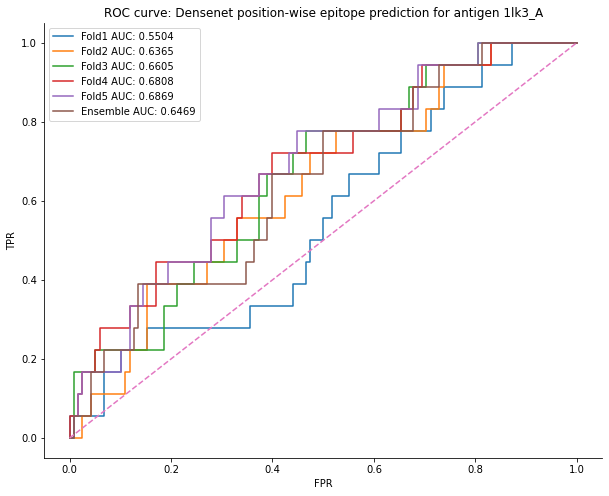

Concatenated all model predictions AUC: 0.6374764595103578
Concatenated all model predictions AUC10: 0.1216572504708098
Concatenated all model predictions MCC: 0.12850656103743013
Concatenated all model predictions recall 0.8888888888888888
Concatenated all model predictions precision: 0.15779092702169625
Concatenated all model predictions F1 score: 0.26800670016750416
Concatenated all model predictions accuracy: 0.3573529411764706
Latex format: & 0.637 & 0.122 & 0.129 & 0.889 & 0.158 & 0.268 & 0.357
Average AUC across all models 0.643
Average AUC10 across all models 0.042
Average CE loss across all models 0.398
Average MCC across all models 0.135
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.889
Average precision across all models 0.16
Average F1-score across all models 0.27
Average accuracy across all models 0.357
Overfit threshold values [0.056, 0.07, 0.075, 0.08, 0.085]
Fold1
AUC10: 0.1168
Neg. log. likelihood loss: 0.3332 Ac

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Ensemble AUC10 0.1236 Neg. log likelihood loss: 0.3257 Accuracy: 0.3814 MCC: 0.219
Positive recall: 1.0 Precision: 0.1609 F1-score: 0.2772 when using optimized threshold
Save directory was already there. Saving it there.


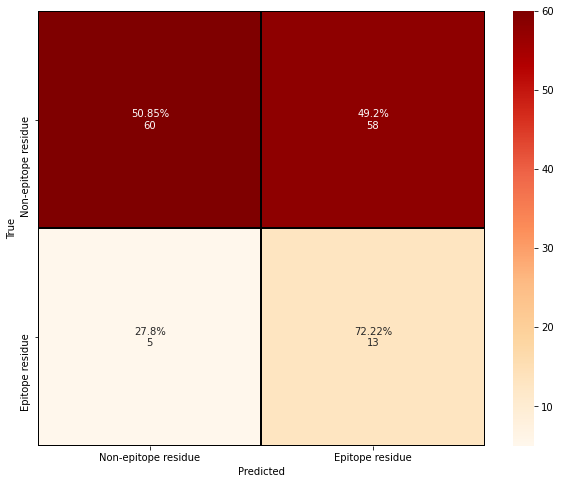

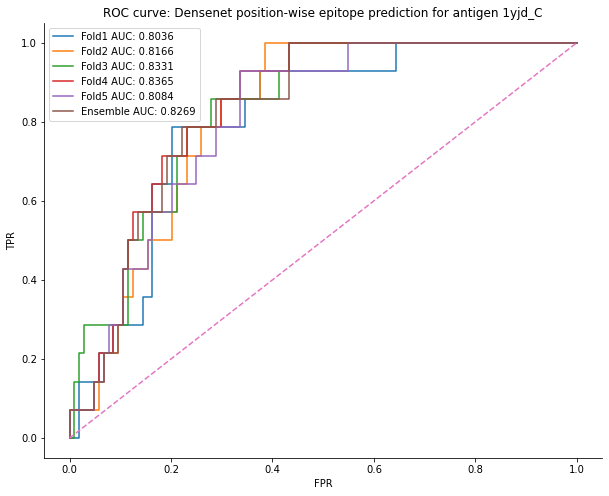

Concatenated all model predictions AUC: 0.8128021978021978
Concatenated all model predictions AUC10: 0.15274725274725273
Concatenated all model predictions MCC: 0.23342489046196313
Concatenated all model predictions recall 1.0
Concatenated all model predictions precision: 0.16666666666666666
Concatenated all model predictions F1 score: 0.2857142857142857
Concatenated all model predictions accuracy: 0.4067796610169492
Latex format: & 0.813 & 0.153 & 0.233 & 1.0 & 0.167 & 0.286 & 0.407
Average AUC across all models 0.82
Average AUC10 across all models 0.092
Average CE loss across all models 0.327
Average MCC across all models 0.235
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 1.0
Average precision across all models 0.169
Average F1-score across all models 0.289
Average accuracy across all models 0.407
Overfit threshold values [0.092, 0.083, 0.108, 0.095, 0.093]
Fold1
AUC10: 0.0
Neg. log. likelihood loss: 0.5271 Accuracy: 0.4353 MCC:

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Save directory was already there. Saving it there.


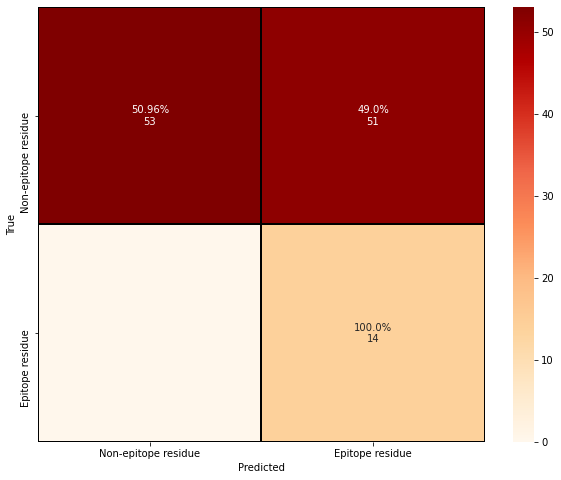

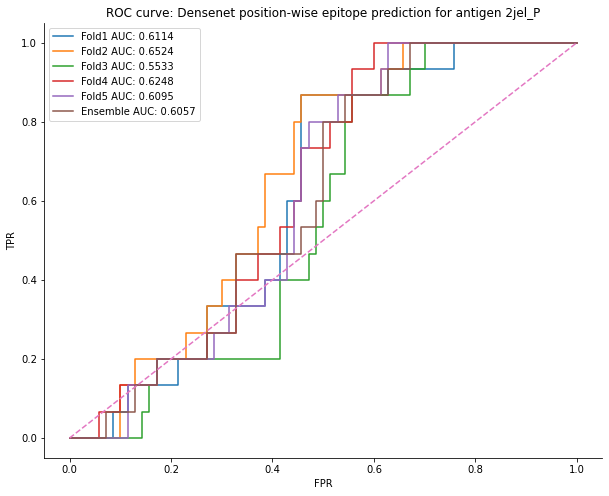

Concatenated all model predictions AUC: 0.6046857142857143
Concatenated all model predictions AUC10: 0.012571428571428577
Concatenated all model predictions MCC: 0.1880607398152376
Concatenated all model predictions recall 0.8266666666666667
Concatenated all model predictions precision: 0.23134328358208955
Concatenated all model predictions F1 score: 0.3615160349854227
Concatenated all model predictions accuracy: 0.48470588235294115
Latex format: & 0.605 & 0.013 & 0.188 & 0.827 & 0.231 & 0.362 & 0.485
Average AUC across all models 0.61
Average AUC10 across all models 0.006
Average CE loss across all models 0.513
Average MCC across all models 0.197
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.827
Average precision across all models 0.228
Average F1-score across all models 0.354
Average accuracy across all models 0.485
Overfit threshold values [0.059, 0.072, 0.068, 0.054, 0.061]
Fold1
AUC10: 0.0874
Neg. log. likelihood loss: 0.322

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Neg. log. likelihood loss: 0.3317 Accuracy: 0.7817 MCC: 0.1326
Positive recall: 0.3333333333333333 Precision: 0.1905 F1-score: 0.2424
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.75
Recall: 0.3333333333333333
Precision: 0.19047619047619047
Fold5
AUC10: 0.0285
Neg. log. likelihood loss: 0.3253 Accuracy: 0.4934 MCC: 0.1779
Positive recall: 0.8333333333333334 Precision: 0.1515 F1-score: 0.2564
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.42
Recall: 0.8333333333333334
Precision: 0.15151515151515152
Ensemble AUC10 0.0224 Neg. log likelihood loss: 0.3285 Accuracy: 0.5459 MCC: 0.1892
Positive recall: 0.7917 Precision: 0.161 F1-score: 0.2676 when using optimized threshold
Save directory was already there. Saving it there.


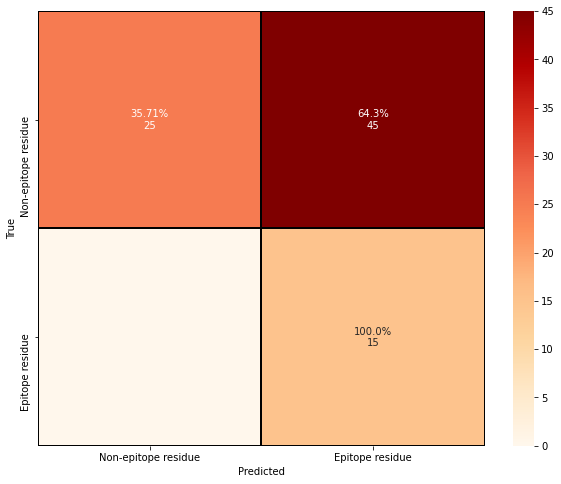

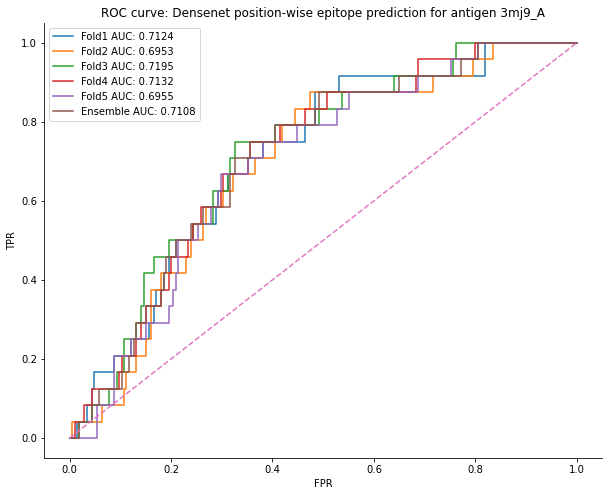

Concatenated all model predictions AUC: 0.6984634146341462
Concatenated all model predictions AUC10: 0.08422764227642277
Concatenated all model predictions MCC: 0.14927893216590865
Concatenated all model predictions recall 0.675
Concatenated all model predictions precision: 0.15458015267175573
Concatenated all model predictions F1 score: 0.25155279503105593
Concatenated all model predictions accuracy: 0.5790393013100437
Latex format: & 0.698 & 0.084 & 0.149 & 0.675 & 0.155 & 0.252 & 0.579
Average AUC across all models 0.707
Average AUC10 across all models 0.057
Average CE loss across all models 0.329
Average MCC across all models 0.162
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.675
Average precision across all models 0.165
Average F1-score across all models 0.254
Average accuracy across all models 0.579
Overfit threshold values [0.055, 0.045, 0.078, 0.059, 0.073]
Fold1
AUC10: 0.1145
Neg. log. likelihood loss: 0.4601 Accuracy: 

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Neg. log. likelihood loss: 0.4372 Accuracy: 0.6078 MCC: 0.0366
Positive recall: 0.4090909090909091 Precision: 0.1607 F1-score: 0.2308
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.6078431372549019
Recall: 0.4090909090909091
Precision: 0.16071428571428573
Fold5
AUC10: 0.0729
Neg. log. likelihood loss: 0.4226 Accuracy: 0.3399 MCC: 0.0319
Positive recall: 0.7727272727272727 Precision: 0.1504 F1-score: 0.2519
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.33986928104575165
Recall: 0.7727272727272727
Precision: 0.1504424778761062
Ensemble AUC10 0.0659 Neg. log likelihood loss: 0.4406 Accuracy: 0.4379 MCC: 0.0568
Positive recall: 0.6818 Precision: 0.1596 F1-score: 0.2586 when using optimized threshold
Save directory was already there. Saving it there.


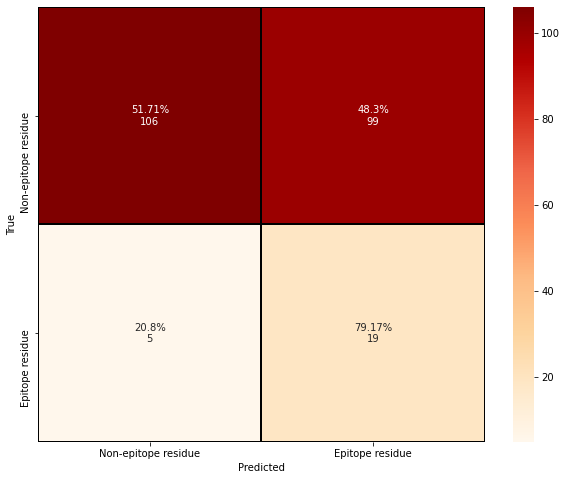

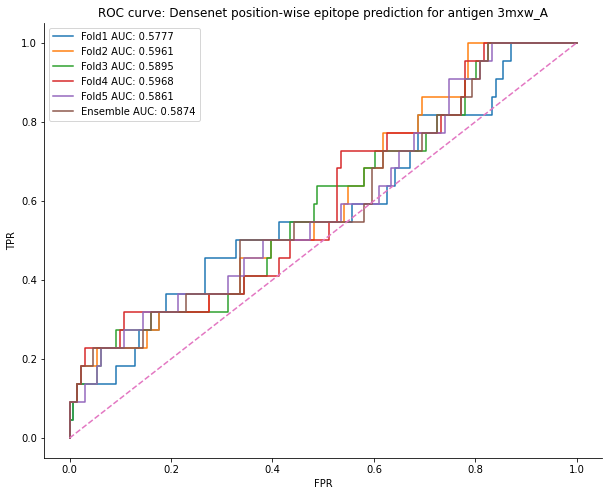

Concatenated all model predictions AUC: 0.5847328244274809
Concatenated all model predictions AUC10: 0.10742539902845245
Concatenated all model predictions MCC: 0.0496731548701163
Concatenated all model predictions recall 0.6363636363636364
Concatenated all model predictions precision: 0.15873015873015872
Concatenated all model predictions F1 score: 0.2540834845735027
Concatenated all model predictions accuracy: 0.4627450980392157
Latex format: & 0.585 & 0.107 & 0.05 & 0.636 & 0.159 & 0.254 & 0.463
Average AUC across all models 0.589
Average AUC10 across all models 0.121
Average CE loss across all models 0.442
Average MCC across all models 0.052
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.636
Average precision across all models 0.159
Average F1-score across all models 0.252
Average accuracy across all models 0.463
Overfit threshold values [0.078, 0.034, 0.108, 0.099, 0.123]
Fold1
AUC10: 0.0645
Neg. log. likelihood loss: 0.3498 

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Fold4
AUC10: 0.0453
Neg. log. likelihood loss: 0.3576 Accuracy: 0.9091 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.88
Recall: 0.0
Precision: 0.0
Fold5
AUC10: 0.0316
Neg. log. likelihood loss: 0.3263 Accuracy: 0.8182 MCC: 0.058
Positive recall: 0.18518518518518517 Precision: 0.1351 F1-score: 0.1562
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.75
Recall: 0.21739130434782608
Precision: 0.13513513513513514
Ensemble AUC10 0.037 Neg. log likelihood loss: 0.3485 Accuracy: 0.8552 MCC: 0.0085
Positive recall: 0.0741 Precision: 0.1 F1-score: 0.0851 when using optimized threshold
Save directory was already there. Saving it there.


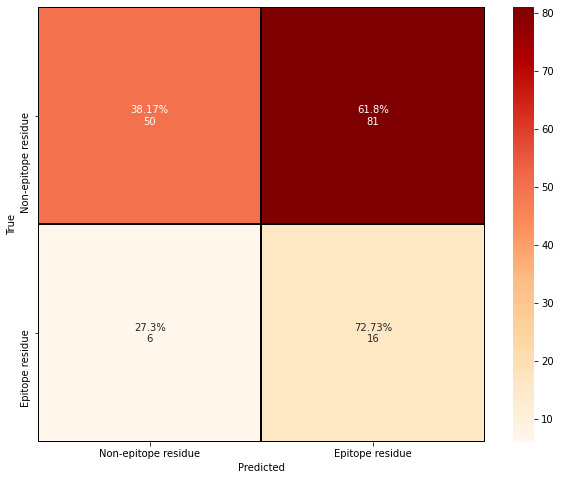

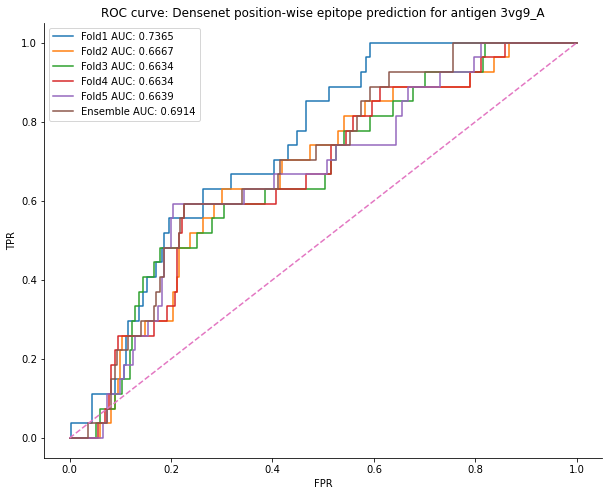

Concatenated all model predictions AUC: 0.6622441700960219
Concatenated all model predictions AUC10: 0.07368998628257886
Concatenated all model predictions MCC: 0.05247153371589096
Concatenated all model predictions recall 0.1037037037037037
Concatenated all model predictions precision: 0.14893617021276595
Concatenated all model predictions F1 score: 0.1222707423580786
Concatenated all model predictions accuracy: 0.8646464646464647
Latex format: & 0.662 & 0.074 & 0.052 & 0.104 & 0.149 & 0.122 & 0.865
Average AUC across all models 0.679
Average AUC10 across all models 0.039
Average CE loss across all models 0.35
Average MCC across all models 0.039
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.104
Average precision across all models 0.085
Average F1-score across all models 0.092
Average accuracy across all models 0.865
Overfit threshold values [0.01, 0.02, 0.039, 0.027, 0.046]
Fold1
AUC10: 0.2309
Neg. log. likelihood loss: 0.2492 A

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.6277372262773723
Recall: 0.9090909090909091
Precision: 0.16666666666666666
Fold5
AUC10: 0.0289
Neg. log. likelihood loss: 0.2589 Accuracy: 0.2628 MCC: 0.1396
Positive recall: 1.0 Precision: 0.0982 F1-score: 0.1789
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.26277372262773724
Recall: 1.0
Precision: 0.09821428571428571
Ensemble AUC10 0.202 Neg. log likelihood loss: 0.2554 Accuracy: 0.3139 MCC: 0.1631
Positive recall: 1.0 Precision: 0.1048 F1-score: 0.1897 when using optimized threshold
Save directory was already there. Saving it there.


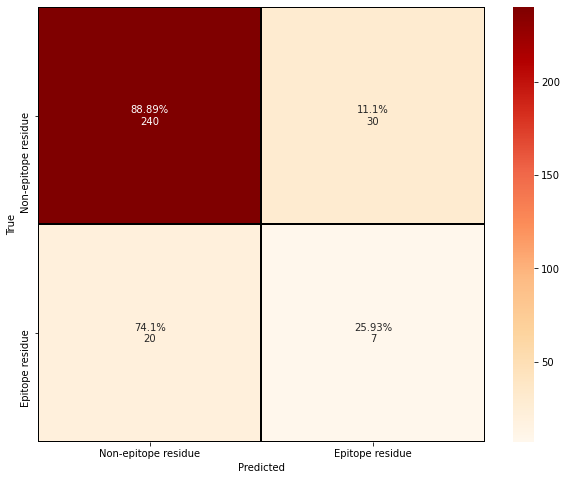

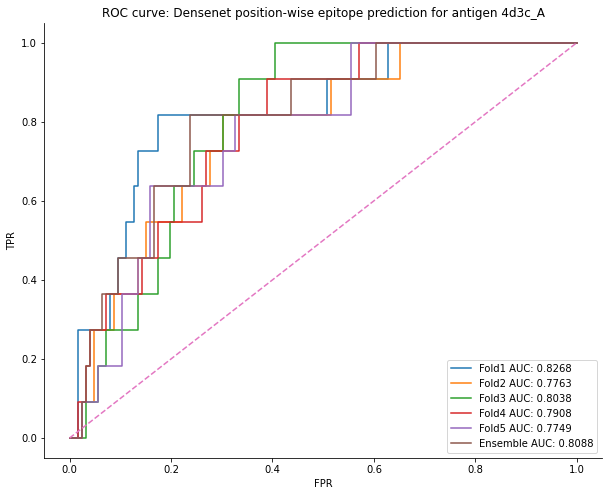

Concatenated all model predictions AUC: 0.7896103896103897
Concatenated all model predictions AUC10: 0.1670995670995671
Concatenated all model predictions MCC: 0.1758617533147601
Concatenated all model predictions recall 0.9818181818181818
Concatenated all model predictions precision: 0.11065573770491803
Concatenated all model predictions F1 score: 0.19889502762430938
Concatenated all model predictions accuracy: 0.36496350364963503
Latex format: & 0.79 & 0.167 & 0.176 & 0.982 & 0.111 & 0.199 & 0.365
Average AUC across all models 0.795
Average AUC10 across all models 0.111
Average CE loss across all models 0.256
Average MCC across all models 0.181
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.982
Average precision across all models 0.116
Average F1-score across all models 0.206
Average accuracy across all models 0.365
Overfit threshold values [0.1, 0.078, 0.077, 0.08, 0.092]
Fold1
AUC10: 0.0794
Neg. log. likelihood loss: 0.3664 Ac

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Neg. log. likelihood loss: 0.3511 Accuracy: 0.2655 MCC: 0.1522
Positive recall: 1.0 Precision: 0.1391 F1-score: 0.2442
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.2655367231638418
Recall: 1.0
Precision: 0.1390728476821192
Ensemble AUC10 0.1954 Neg. log likelihood loss: 0.3546 Accuracy: 0.2712 MCC: 0.1557
Positive recall: 1.0 Precision: 0.14 F1-score: 0.2456 when using optimized threshold
Save directory was already there. Saving it there.


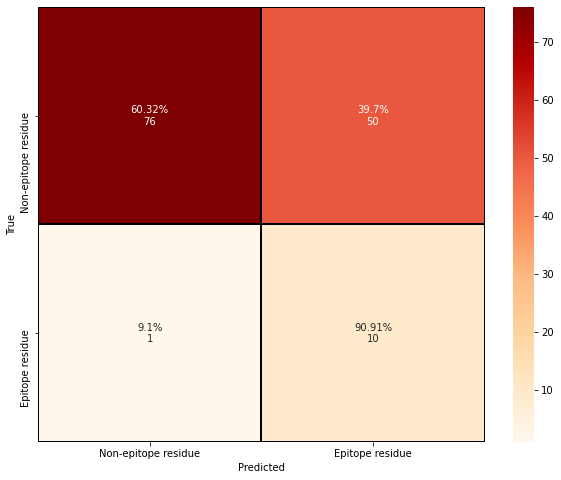

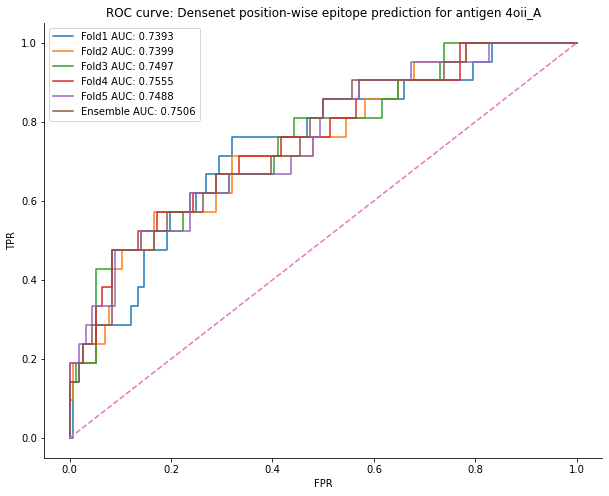

Concatenated all model predictions AUC: 0.7324908424908425
Concatenated all model predictions AUC10: 0.26520146520146515
Concatenated all model predictions MCC: 0.14372857915502446
Concatenated all model predictions recall 0.9428571428571428
Concatenated all model predictions precision: 0.14327062228654125
Concatenated all model predictions F1 score: 0.24874371859296482
Concatenated all model predictions accuracy: 0.32429378531073444
Latex format: & 0.732 & 0.265 & 0.144 & 0.943 & 0.143 & 0.249 & 0.324
Average AUC across all models 0.747
Average AUC10 across all models 0.193
Average CE loss across all models 0.355
Average MCC across all models 0.155
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.943
Average precision across all models 0.15
Average F1-score across all models 0.255
Average accuracy across all models 0.324
Overfit threshold values [0.064, 0.083, 0.107, 0.088, 0.103]
Fold1
AUC10: 0.0
Neg. log. likelihood loss: 0.3121 

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.2898550724637681
Recall: 1.0
Precision: 0.125
Ensemble AUC10 0.1843 Neg. log likelihood loss: 0.3107 Accuracy: 0.2899 MCC: 0.1619
Positive recall: 1.0 Precision: 0.125 F1-score: 0.2222 when using optimized threshold
Save directory was already there. Saving it there.


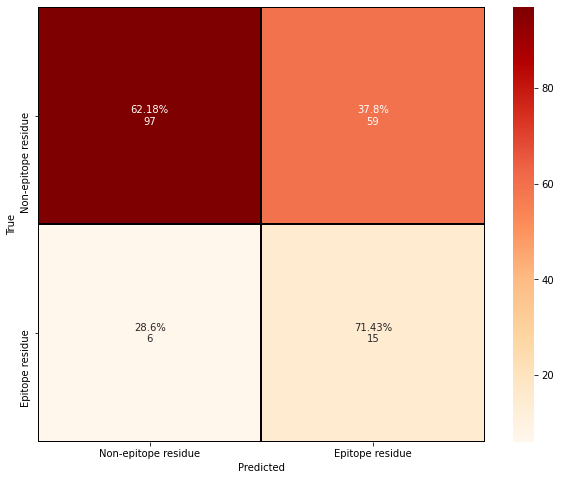

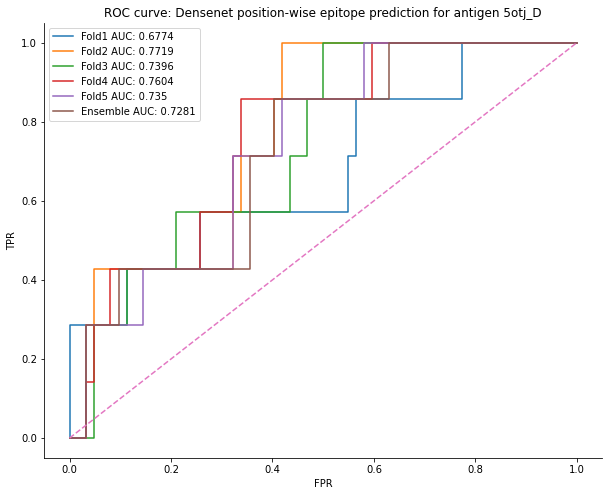

Concatenated all model predictions AUC: 0.7353917050691244
Concatenated all model predictions AUC10: 0.15760368663594468
Concatenated all model predictions MCC: 0.18091259604236176
Concatenated all model predictions recall 0.9714285714285714
Concatenated all model predictions precision: 0.13438735177865613
Concatenated all model predictions F1 score: 0.23611111111111113
Concatenated all model predictions accuracy: 0.36231884057971014
Latex format: & 0.735 & 0.158 & 0.181 & 0.971 & 0.134 & 0.236 & 0.362
Average AUC across all models 0.737
Average AUC10 across all models 0.032
Average CE loss across all models 0.311
Average MCC across all models 0.187
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.971
Average precision across all models 0.142
Average F1-score across all models 0.246
Average accuracy across all models 0.362
Overfit threshold values [0.111, 0.079, 0.068, 0.082, 0.08]
Fold1
AUC10: 0.2902
Neg. log. likelihood loss: 0.45

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.2564102564102564
Recall: 1.0
Precision: 0.19444444444444445
Ensemble AUC10 0.0893 Neg. log likelihood loss: 0.4593 Accuracy: 0.2949 MCC: 0.1689
Positive recall: 1.0 Precision: 0.2029 F1-score: 0.3373 when using optimized threshold
Save directory was already there. Saving it there.


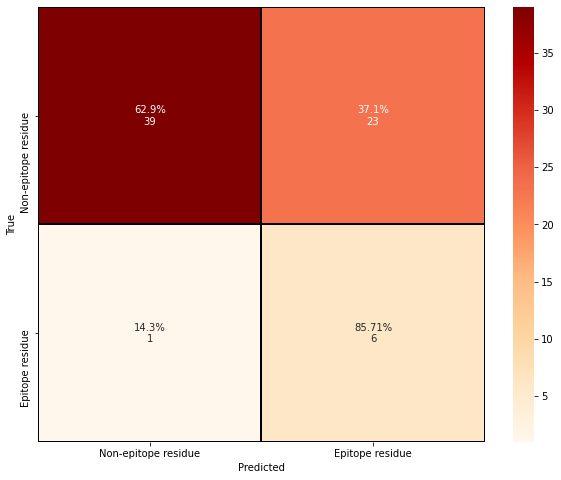

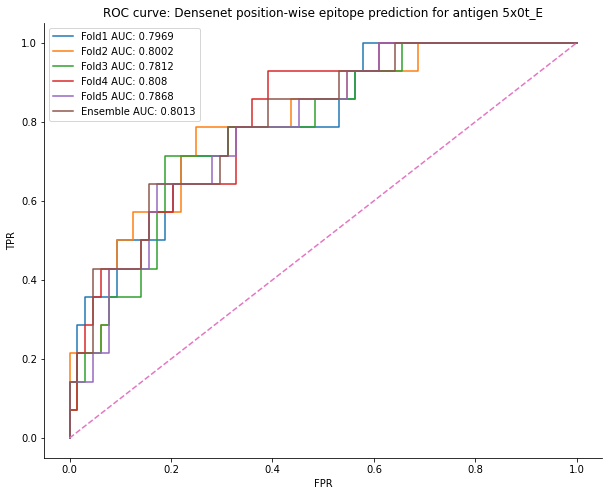

Concatenated all model predictions AUC: 0.7925892857142858
Concatenated all model predictions AUC10: 0.2522321428571429
Concatenated all model predictions MCC: 0.16815476190476192
Concatenated all model predictions recall 0.9857142857142858
Concatenated all model predictions precision: 0.20535714285714285
Concatenated all model predictions F1 score: 0.3399014778325123
Concatenated all model predictions accuracy: 0.3128205128205128
Latex format: & 0.793 & 0.252 & 0.168 & 0.986 & 0.205 & 0.34 & 0.313
Average AUC across all models 0.795
Average AUC10 across all models 0.192
Average CE loss across all models 0.46
Average MCC across all models 0.167
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.986
Average precision across all models 0.208
Average F1-score across all models 0.343
Average accuracy across all models 0.313
Overfit threshold values [0.115, 0.106, 0.119, 0.099, 0.121]
Fold1
AUC10: 0.1067
Neg. log. likelihood loss: 0.5714 A

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Save directory was already there. Saving it there.


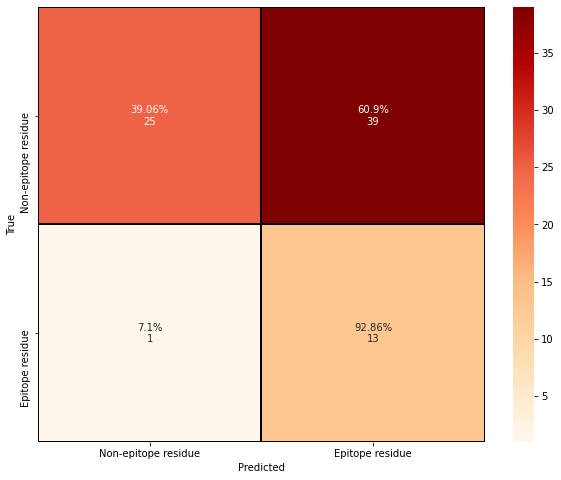

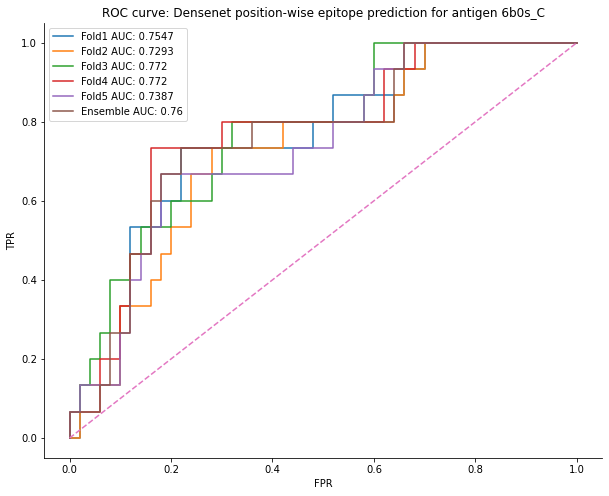

Concatenated all model predictions AUC: 0.7573333333333333
Concatenated all model predictions AUC10: 0.16213333333333335
Concatenated all model predictions MCC: 0.18296613945518583
Concatenated all model predictions recall 0.9866666666666667
Concatenated all model predictions precision: 0.2596491228070175
Concatenated all model predictions F1 score: 0.4111111111111111
Concatenated all model predictions accuracy: 0.3476923076923077
Latex format: & 0.757 & 0.162 & 0.183 & 0.987 & 0.26 & 0.411 & 0.348
Average AUC across all models 0.753
Average AUC10 across all models 0.117
Average CE loss across all models 0.577
Average MCC across all models 0.184
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.987
Average precision across all models 0.261
Average F1-score across all models 0.413
Average accuracy across all models 0.348
Overfit threshold values [0.113, 0.102, 0.098, 0.116, 0.111]
Fold1
AUC10: 0.0137
Neg. log. likelihood loss: 0.1512 

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Neg. log. likelihood loss: 0.1532 Accuracy: 0.92 MCC: -0.0416
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.87
Recall: 0.0
Precision: 0.0
Fold4
AUC10: 0.0
Neg. log. likelihood loss: 0.1566 Accuracy: 0.9629 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.94
Recall: 0.0
Precision: 0.0
Fold5
AUC10: 0.0046
Neg. log. likelihood loss: 0.1499 Accuracy: 0.92 MCC: -0.0416
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.865
Recall: 0.0
Precision: 0.0
Ensemble AUC10 0.0137 Neg. log likelihood loss: 0.1532 Accuracy: 0.9371 MCC: -0.0319
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold
Save directory was already there. Saving it there.


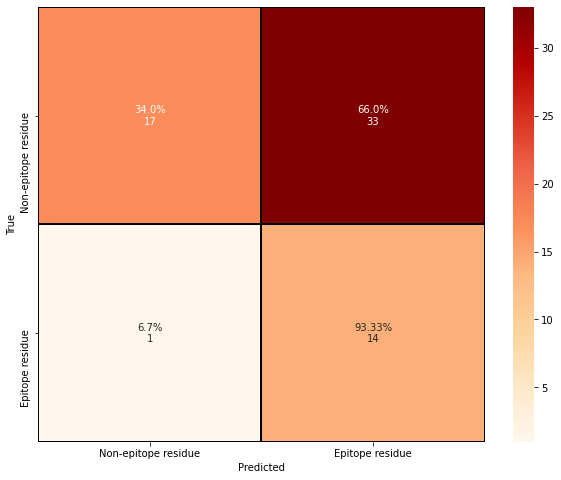

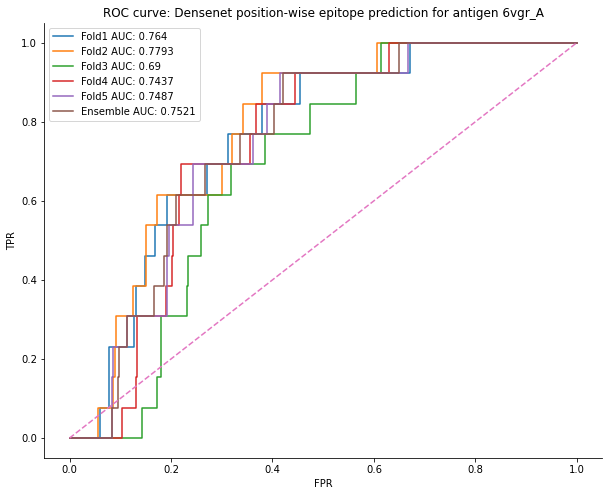

Concatenated all model predictions AUC: 0.7132800730426843
Concatenated all model predictions AUC10: 0.04245606026021457
Concatenated all model predictions MCC: 0.012810266362320157
Concatenated all model predictions recall 0.046153846153846156
Concatenated all model predictions precision: 0.05
Concatenated all model predictions F1 score: 0.048
Concatenated all model predictions accuracy: 0.932
Latex format: & 0.713 & 0.042 & 0.013 & 0.046 & 0.05 & 0.048 & 0.932
Average AUC across all models 0.745
Average AUC10 across all models 0.01
Average CE loss across all models 0.154
Average MCC across all models 0.004
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.046
Average precision across all models 0.02
Average F1-score across all models 0.028
Average accuracy across all models 0.932
Overfit threshold values [0.019, 0.015, 0.02, 0.02, 0.031]
Fold1
AUC10: 0.2359
Neg. log. likelihood loss: 0.2113 Accuracy: 0.3539 MCC: 0.1704
Positive rec

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.7696629213483146
Recall: 0.75
Precision: 0.19148936170212766
Fold5
AUC10: 0.2058
Neg. log. likelihood loss: 0.2215 Accuracy: 0.3596 MCC: 0.1727
Positive recall: 1.0 Precision: 0.0952 F1-score: 0.1739
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.3595505617977528
Recall: 1.0
Precision: 0.09523809523809523
Ensemble AUC10 0.2108 Neg. log likelihood loss: 0.219 Accuracy: 0.4382 MCC: 0.2064
Positive recall: 1.0 Precision: 0.1071 F1-score: 0.1935 when using optimized threshold
Save directory was already there. Saving it there.


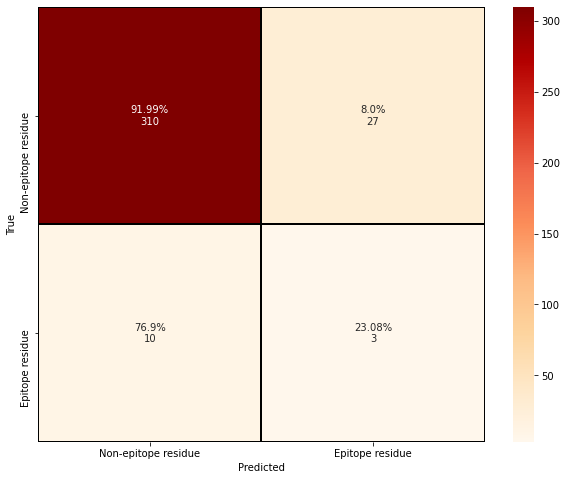

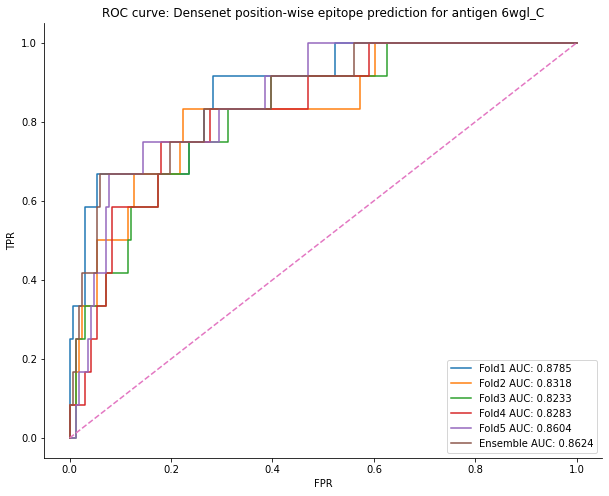

Concatenated all model predictions AUC: 0.8242168674698794
Concatenated all model predictions AUC10: 0.26305220883534136
Concatenated all model predictions MCC: 0.195639495837537
Concatenated all model predictions recall 0.9166666666666666
Concatenated all model predictions precision: 0.11133603238866396
Concatenated all model predictions F1 score: 0.19855595667870035
Concatenated all model predictions accuracy: 0.501123595505618
Latex format: & 0.824 & 0.263 & 0.196 & 0.917 & 0.111 & 0.199 & 0.501
Average AUC across all models 0.844
Average AUC10 across all models 0.19
Average CE loss across all models 0.22
Average MCC across all models 0.212
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.917
Average precision across all models 0.124
Average F1-score across all models 0.214
Average accuracy across all models 0.501
Overfit threshold values [0.06, 0.065, 0.089, 0.085, 0.105]
Fold1
AUC10: 0.0154
Neg. log. likelihood loss: 0.2246 Acc

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Fold4
AUC10: 0.0419
Neg. log. likelihood loss: 0.2317 Accuracy: 0.942 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.895
Recall: 0.0
Precision: 0.0
Fold5
AUC10: 0.0
Neg. log. likelihood loss: 0.2234 Accuracy: 0.9392 MCC: -0.0131
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.89
Recall: 0.0
Precision: 0.0
Ensemble AUC10 0.0279 Neg. log likelihood loss: 0.2291 Accuracy: 0.942 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold
Save directory was already there. Saving it there.


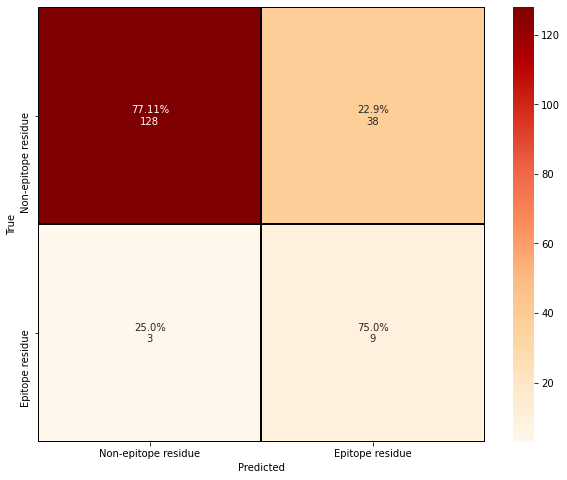

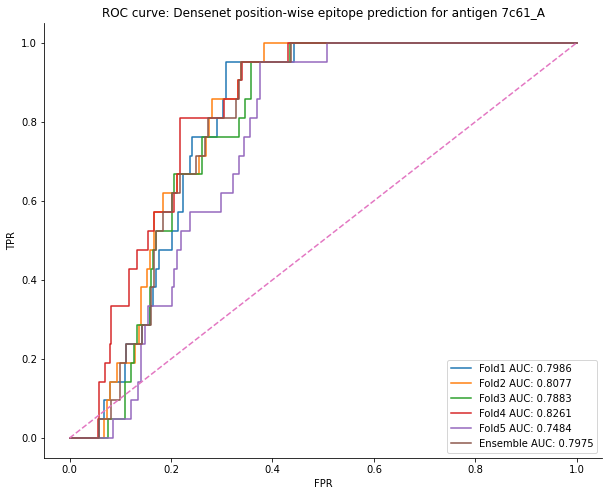

Concatenated all model predictions AUC: 0.7682279011311269
Concatenated all model predictions AUC10: 0.06015919564306659
Concatenated all model predictions MCC: -0.022685369681766532
Concatenated all model predictions recall 0.0
Concatenated all model predictions precision: 0.0
Concatenated all model predictions F1 score: 0.0
Concatenated all model predictions accuracy: 0.9337016574585635
Latex format: & 0.768 & 0.06 & -0.023 & 0.0 & 0.0 & 0.0 & 0.934
Average AUC across all models 0.794
Average AUC10 across all models 0.017
Average CE loss across all models 0.23
Average MCC across all models -0.013
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.0
Average precision across all models 0.0
Average F1-score across all models 0.0
Average accuracy across all models 0.934
Overfit threshold values [0.023, 0.014, 0.025, 0.019, 0.027]
Fold1
AUC10: 0.0212
Neg. log. likelihood loss: 0.1983 Accuracy: 0.9235 MCC: 0.0328
Positive recall: 0.0625 P

C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:25: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  lchain_test = np.asarray(lchain_test_to_eval, dtype="object")
C:\Users\Joaki\AppData\Local\Temp/ipykernel_10908/3673550251.py:26: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either 

Fold4
AUC10: 0.0
Neg. log. likelihood loss: 0.1981 Accuracy: 0.9529 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.955
Recall: 0.0
Precision: 0.0
Fold5
AUC10: 0.0039
Neg. log. likelihood loss: 0.1933 Accuracy: 0.95 MCC: -0.0121
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.95
Recall: 0.0
Precision: 0.0
Ensemble AUC10 0.0 Neg. log likelihood loss: 0.1965 Accuracy: 0.9529 MCC: 0.0
Positive recall: 0.0 Precision: 0.0 F1-score: 0.0 when using optimized threshold
Save directory was already there. Saving it there.


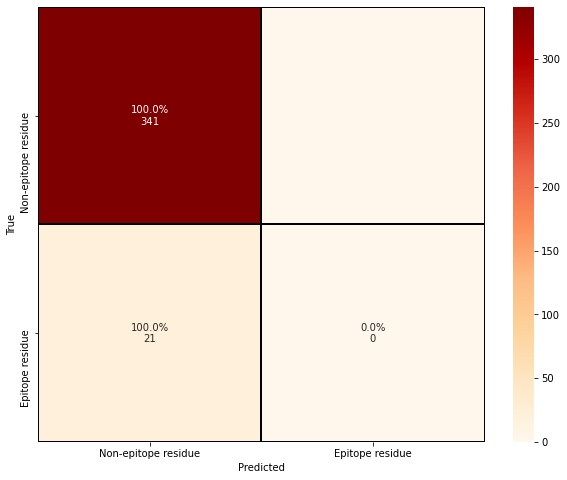

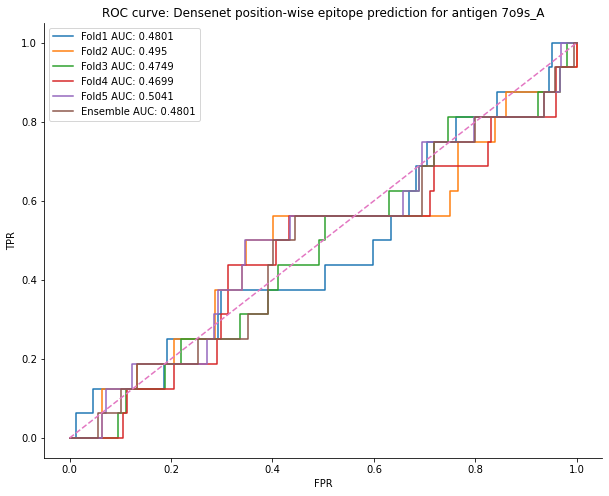

Concatenated all model predictions AUC: 0.4825308641975309
Concatenated all model predictions AUC10: 0.03225308641975309
Concatenated all model predictions MCC: 0.0002958642554452021
Concatenated all model predictions recall 0.0125
Concatenated all model predictions precision: 0.047619047619047616
Concatenated all model predictions F1 score: 0.019801980198019806
Concatenated all model predictions accuracy: 0.941764705882353
Latex format: & 0.483 & 0.032 & 0.0 & 0.012 & 0.048 & 0.02 & 0.942
Average AUC across all models 0.485
Average AUC10 across all models 0.005
Average CE loss across all models 0.197
Average MCC across all models -0.003
Fold threshold values: [0.039, 0.058, 0.058, 0.078, 0.058]
Average positive recall across all models 0.012
Average precision across all models 0.017
Average F1-score across all models 0.014
Average accuracy across all models 0.942
Overfit threshold values [0.037, 0.025, 0.03, 0.029, 0.037]


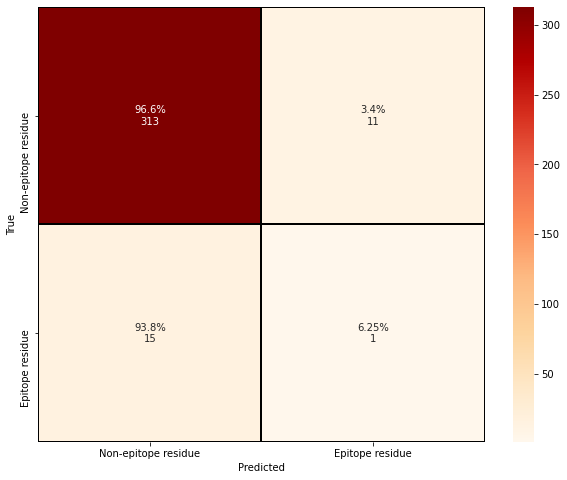

In [57]:
class MyDenseNet(nn.Module):
    def __init__(self,
                 esm_embedding_size = 1281,
                 fc1_lc_or_hc_size = 150,
                 fc2_lc_or_hc_size = 75,
                 fc1_size = 180,
                 fc2_size = 90,
                 fc3_size = 45,
                 fc1_dropout = 0.7,
                 fc2_dropout = 0.7,
                 fc3_dropout = 0.7,
                 num_of_classes = 2):
        super(MyDenseNet, self).__init__()
        
        
        self.esm_embedding_size = esm_embedding_size
        self.fc1_lc_or_hc_size = fc1_lc_or_hc_size 
        self.fc2_lc_or_hc_size = fc2_lc_or_hc_size
        self.fc1_size = fc1_size
        self.fc2_size = fc2_size
        self.fc3_size = fc3_size
        self.fc1_dropout = fc1_dropout
        self.fc2_dropout = fc2_dropout
        self.fc3_dropout = fc3_dropout
        
        #extract antigen features
        self.antigen_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
                                                 nn.ReLU(),
                                                 nn.Dropout(fc1_dropout),
                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        
        #light chain densenet (batch*sequence lengths)
        self.light_chain_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
                                                 nn.ReLU(),
                                                 nn.Dropout(fc1_dropout),
                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        #heavy chain densenet (batch*sequence lengths)
        self.heavy_chain_ff_model = nn.Sequential(nn.Linear(esm_embedding_size, fc1_lc_or_hc_size),
                                                 nn.ReLU(),
                                                 nn.Dropout(fc1_dropout),
                                                 nn.Linear(fc1_lc_or_hc_size, fc2_lc_or_hc_size))
        
        
        #Positionwise antigen densenet (1281+50+50 from light and heavy chain)
        self.ff_model = nn.Sequential(nn.Linear(fc2_lc_or_hc_size*3, fc1_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc1_dropout),
                                      nn.Linear(fc1_size, fc2_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc2_dropout),
                                      nn.Linear(fc2_size, fc3_size),
                                      nn.ReLU(),
                                      nn.Dropout(fc3_dropout),
                                      nn.Linear(fc3_size, num_of_classes))
        
    def forward(self, antigen, light_chain, heavy_chain):
        antigen, original_lengths = pad_packed_sequence(antigen, batch_first=True)
        batch_size = antigen.size(0)
        seq_len = antigen.size(1)
        #convert dim (N, L, esm_embedding) --> (N*L, esm_embedding)
        antigen = torch.reshape(antigen, (batch_size*seq_len, self.esm_embedding_size))
        
        antigen_features = self.antigen_ff_model(antigen)
        
        #light and heavy chain repeats for as many positions in antigen. (N, esm_embedding) -> (N*L, esm_embedding)
#        light_chain = [pos.repeat(seq_len, 1) for pos in light_chain]
#        light_chain = torch.reshape(torch.stack(light_chain), (batch_size*seq_len, self.esm_embedding_size))
#        heavy_chain = [pos.repeat(seq_len, 1) for pos in heavy_chain]
#        heavy_chain = torch.reshape(torch.stack(heavy_chain), (batch_size*seq_len, self.esm_embedding_size))
        
        #get light chain features
        light_chain_features = self.light_chain_ff_model(light_chain)
        light_chain_features = torch.stack([chain.repeat(seq_len, 1) for chain in light_chain_features])
        light_chain_features = torch.reshape(light_chain_features, (batch_size*seq_len, self.fc2_lc_or_hc_size))
        #get heavy chain features
        heavy_chain_features = self.heavy_chain_ff_model(heavy_chain)
        heavy_chain_features = torch.stack([chain.repeat(seq_len, 1) for chain in heavy_chain_features])
        heavy_chain_features = torch.reshape(heavy_chain_features, (batch_size*seq_len, self.fc2_lc_or_hc_size))
        
        #concatenate antigen esm embeddings with light and heavy chain features
        antigen_antibody_features = torch.cat((antigen_features, light_chain_features, heavy_chain_features), axis=1)
        output = self.ff_model(antigen_antibody_features)                                               
        return output

In [58]:
model = MyDenseNet()

Untrained model performance
AUC10: 0.0079
Neg. log. likelihood loss: 0.7167 Accuracy: 0.0778 MCC: 0.0
Positive recall: 1.0 Precision: 0.0778 F1-score: 0.1443
Accuaracy, recall and precision on top-200 assigned highest pos. prob
Accuracy: 0.0
Recall: 0.0
Precision: 0.0


C:\Users\Joaki\anaconda3\envs\pytorch_gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


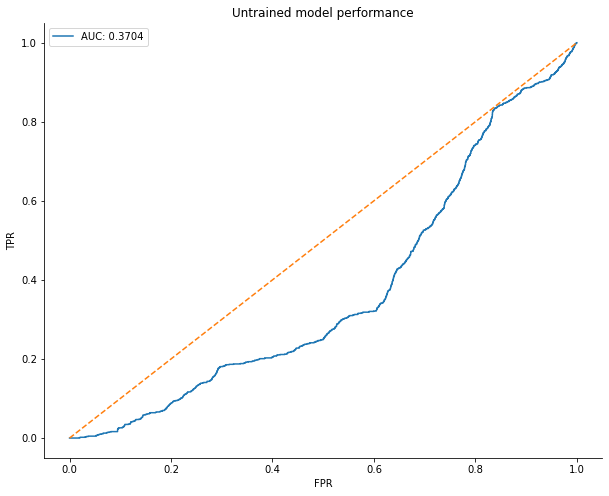

In [59]:
def evaluate_untrained_model_with_roc_curve(model, data_loader, plot_title):
    f, ax = plt.subplots(figsize=(10,8))
    criterion = CrossEntropyLoss(ignore_index = 2)
    all_labels = list()
    model_outputs = list()
    model.eval()
    
    for antigen, lchain, hchain, labels in data_loader:
        output = model(antigen, lchain, hchain)
        model_outputs.append(output)
        labels = torch.flatten(labels)
        all_labels.append(labels)
        
    #create ROC curve
    model_outputs = torch.cat(model_outputs, axis=0)
    all_labels = torch.cat(all_labels, axis=0)
    model_loss = criterion(model_outputs, all_labels)
    y_true_no_pad, y_pos_prob_no_pad = get_labels_preds_and_posprob_without_padding(model_outputs, all_labels)
    fpr, tpr, auc, overfit_thresh = get_fpr_tpr_auc_and_opt_threshold(y_true_no_pad, y_pos_prob_no_pad)
    auc10 = compute_auc10(fpr, tpr)
    acc, mcc, recall, precision, f1_score, predictions = metrics_with_threshold(y_true_no_pad, y_pos_prob_no_pad, 0.1)
    
    
    print("Untrained model performance")
    print(f"AUC10: {round(auc10,4)}")
    print(f"Neg. log. likelihood loss: {round(model_loss.item(),4)} Accuracy: {round(acc,4)} MCC: {round(mcc,4)}")
    print(f"Positive recall: {recall} Precision: {round(precision,4)} F1-score: {round(f1_score,4)}")
    get_top_x_pos_probs_scores(y_pos_prob_no_pad, y_true_no_pad, 0.1, top=200)
    ax.plot(fpr, tpr, label = f"AUC: {round(auc,4)}")
    
    
    ax.plot(np.linspace(0, 1), np.linspace(0, 1), "--")
    ax.legend()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(plot_title)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
#    figure_save_dir = figure_save_path.parent
#    create_figure_save_path(figure_save_dir)
#    plt.savefig(figure_save_path, dpi = 500, bbox_inches= "tight")
    plt.show()
    
test_path = BEPIPRED3_AGAB_SIMPLE_DATASET / "test.npz"
test_set_loader = prepare_test_set_loader(test_path, batch_size = 4)
evaluate_untrained_model_with_roc_curve(model, test_set_loader, "Untrained model performance")